# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet201, EfficientNetB3, ResNet50
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import gc
from tensorflow.keras import backend as K
import itertools
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

tf.random.set_seed(42)
np.random.seed(42)


USE_AUGMENTATION_AND_OVERSAMPLING = False
print(f"Using augmentation and oversampling: {USE_AUGMENTATION_AND_OVERSAMPLING}")

Mounted at /content/drive
Using augmentation and oversampling: False


# Preparing data

In [2]:
data_path = '/content/dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)

import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", 'r')
zip_ref.extractall(data_path)
zip_ref.close()

csv_path = os.path.join(data_path, 'HAM10000_metadata.csv')
images_part1 = os.path.join(data_path, 'HAM10000_images_part_1')
images_part2 = os.path.join(data_path, 'HAM10000_images_part_2')

df_data = pd.read_csv(csv_path).set_index('image_id')

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df_data.dx = df_data.dx.astype('category', copy=True)
df_data['label_numeric'] = df_data.dx.cat.codes
df_data['label'] = df_data.dx
df_data['lesion_type'] = df_data.dx.map(lesion_type_dict)

imageid_path_dict = {}

for image_folder in [images_part1, images_part2]:
    if os.path.exists(image_folder):
        for image_file in os.listdir(image_folder):
            if image_file.endswith('.jpg'):
                image_id = os.path.splitext(image_file)[0]
                imageid_path_dict[image_id] = os.path.join(image_folder, image_file)

df_data['path'] = df_data.index.map(lambda x: imageid_path_dict.get(x, None))

df_data = df_data.dropna(subset=['path'])

print(f"Total images loaded: {len(df_data)}")
print("\nDiagnosis distribution:")
dx_counts = df_data['dx'].value_counts()
for dx, count in dx_counts.items():
    print(f"{lesion_type_dict[dx]} ({dx}): {count} images")

Total images loaded: 10015

Diagnosis distribution:
Melanocytic nevi (nv): 6705 images
Melanoma (mel): 1113 images
Benign keratosis (bkl): 1099 images
Basal cell carcinoma (bcc): 514 images
Actinic keratoses (akiec): 327 images
Vascular lesions (vasc): 142 images
Dermatofibroma (df): 115 images


#  Data Visualization and Split

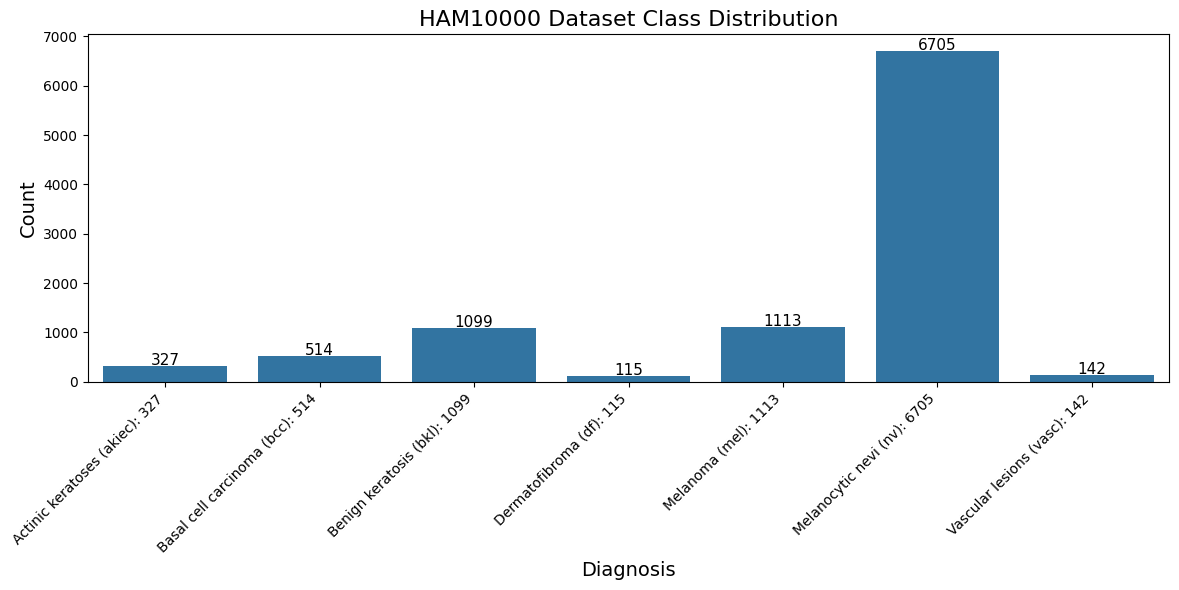

Duplicate lesion_ids: 2545 out of 10015


<ipython-input-3-68a55786744b>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-3-68a55786744b>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


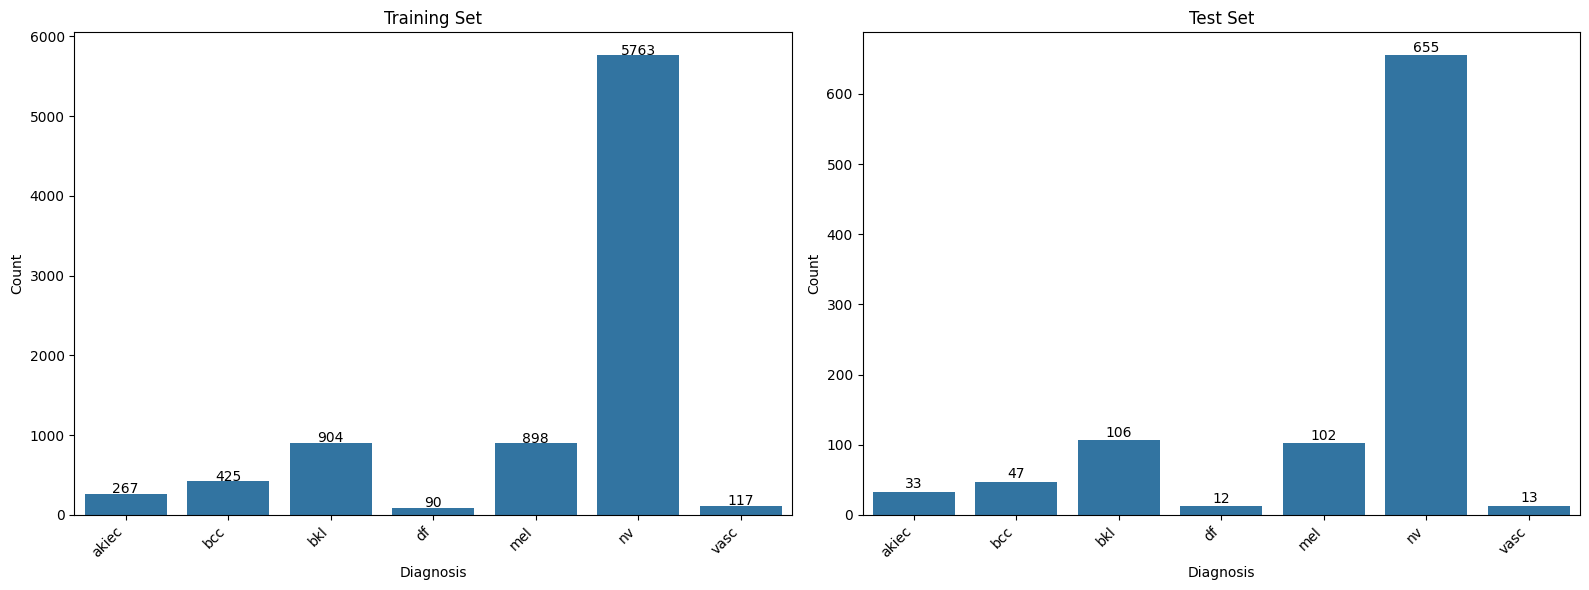

Training set: 8464 images
Test set: 968 images


In [3]:
def plot_data_distribution(df, title='Class Distribution'):
    plt.figure(figsize=(12, 6))
    counts = df['dx'].value_counts().sort_index()

    labels = [f"{lesion_type_dict[dx]} ({dx}): {count}" for dx, count in counts.items()]

    ax = sns.barplot(x=counts.index, y=counts.values)

    plt.title(title, fontsize=16)
    plt.xlabel('Diagnosis', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(range(len(counts)), labels, rotation=45, ha='right')

    for i, count in enumerate(counts.values):
        ax.text(i, count + 20, str(count), ha='center', fontsize=11)

    plt.tight_layout()
    plt.show()

plot_data_distribution(df_data, 'HAM10000 Dataset Class Distribution')

def check_duplicates(df, col='lesion_id'):
    unique_list = df[col].unique().tolist()
    num_duplicates = len(df) - len(unique_list)
    return num_duplicates

num_duplicates = check_duplicates(df_data)
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_data)}')

df_train, df_test = train_test_split(df_data, test_size=0.1, stratify=df_data['label_numeric'], random_state=42)

df_test = df_test.reset_index()
df_train = df_train.reset_index()

df_test = df_test.drop_duplicates(subset='lesion_id', keep="first")

test_lesion_ids = set(df_test['lesion_id'].unique())
df_train = df_train[~df_train['lesion_id'].isin(test_lesion_ids)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (df, title) in enumerate([(df_train, 'Training Set'), (df_test, 'Test Set')]):
    counts = df['dx'].value_counts().sort_index()
    ax = axes[i]
    sns.barplot(x=counts.index, y=counts.values, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diagnosis')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    for j, count in enumerate(counts.values):
        ax.text(j, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

print(f"Training set: {len(df_train)} images")
print(f"Test set: {len(df_test)} images")

# Data Augmentation and Balance Function

In [4]:
def balance_data(train_data, oversample=True):
    if not oversample:
        print("Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False")
        return train_data

    balanced_train_data = []
    class_counts = train_data['label_numeric'].value_counts()

    nv_indices = train_data[train_data['dx'] == 'nv'].index
    nv_label = list(train_data[train_data['dx'] == 'nv']['label_numeric'].unique())[0]

    for class_label, count in class_counts.items():
        class_data = train_data[train_data['label_numeric'] == class_label]
        class_name = list(train_data[train_data['label_numeric'] == class_label]['dx'].unique())[0]

        if class_label == nv_label:
            balanced_train_data.append(class_data)
            print(f"Class '{class_name}' (original): {len(class_data)} samples")
        else:
            if count < 1500:
                n_samples_needed = 1500
                n_oversample = n_samples_needed - count

                full_copies = n_oversample // count
                remaining = n_oversample % count

                oversampled = pd.concat([class_data] * full_copies) if full_copies > 0 else pd.DataFrame()

                if remaining > 0:
                    additional = class_data.sample(n=remaining, replace=False, random_state=42)
                    oversampled = pd.concat([oversampled, additional])

                final_class_data = pd.concat([class_data, oversampled])
                balanced_train_data.append(final_class_data)
                print(f"Class '{class_name}' (oversampled): {len(final_class_data)} samples (original: {count})")
            else:
                balanced_train_data.append(class_data.sample(n=1500, random_state=42))
                print(f"Class '{class_name}' (downsampled): 1500 samples (original: {count})")

    balanced_data = pd.concat(balanced_train_data)
    return balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

common_aug_args = {
    "featurewise_center": False,
    "samplewise_center": False,
    "featurewise_std_normalization": False,
    "samplewise_std_normalization": False,
    "zca_whitening": False,
    "rotation_range": 10,
    "zoom_range": 0.1,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "horizontal_flip": False,
    "vertical_flip": False,
    "fill_mode": 'nearest'
}

if USE_AUGMENTATION_AND_OVERSAMPLING:
    tr_gen_rescale = ImageDataGenerator(rescale=1.0/255.0, **common_aug_args)
    tr_gen_no_rescale = ImageDataGenerator(**common_aug_args)
else:
    tr_gen_rescale = ImageDataGenerator(rescale=1.0/255.0)
    tr_gen_no_rescale = ImageDataGenerator()

ts_gen_rescale = ImageDataGenerator(rescale=1.0/255.0)
ts_gen_no_rescale = ImageDataGenerator()

# Models

In [5]:
def create_densenet_model(input_shape=(224, 224, 3), num_classes=7):
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(num_classes, activation='softmax')
    ])

    return model

def create_efficientnet_model(input_shape=(300, 300, 3), num_classes=7):
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(num_classes, activation='softmax')
    ])

    return model

def create_resnet50_model(input_shape=(112, 150, 3), num_classes=7):
    base_model = ResNet50(
        include_top=False,
        input_shape=input_shape,
        pooling='avg',
        weights='imagenet'
    )

    model = Sequential([
        base_model,
        Dropout(0.5),
        Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.02))
    ])

    return model

def compile_model(model):
    opt = Adam(learning_rate=0.001)
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

model_configs = {
    "ResNet50": {"img_size": (112, 150), "use_rescale": True, "model_func": create_resnet50_model},
    "DenseNet201": {"img_size": (224, 224), "use_rescale": True, "model_func": create_densenet_model},
    "EfficientNetB3": {"img_size": (300, 300), "use_rescale": False, "model_func": create_efficientnet_model}
}

# Functions for Visualization

In [6]:
def plot_roc_curves(fpr, tpr, roc_auc, class_names, title='ROC Curves'):
    plt.figure(figsize=(12, 10))

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_training_history(history, model_name):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Training')
    if 'val_auc' in history.history:
        plt.plot(history.history['val_auc'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title(f'{model_name} - AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# K-Fold Cross-Validation Training


Starting 5-Fold CV for model: ResNet50

--- Fold 1 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 23,797,767 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 145s 395ms/step - accuracy: 0.6586 - auc: 0.9109 - loss: 4.1160 - val_accuracy: 0.6810 - val_auc: 0.8139 - val_loss: 13.0914 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 50s 236ms/step - accuracy: 0.7324 - auc: 0.9493 - loss: 1.1906 - val_accuracy: 0.6810 - val_auc: 0.8936 - val_loss: 1.3011 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 230ms/step - accuracy: 0.7685 - auc: 0.9629 - loss: 0.8287 - val_accuracy: 0.6810 - val_auc: 0.8478 - val_loss: 2.0341 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7883 - auc: 0.9668 - loss: 0.7412
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 230ms/step - accuracy: 0.7883 - auc: 0.9668 - loss: 0.7412 - val_accuracy: 0.6775 - val_auc: 0.8502 - val_loss: 1.4445 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 50s 234ms/step - accuracy: 0.8079 - auc: 0.

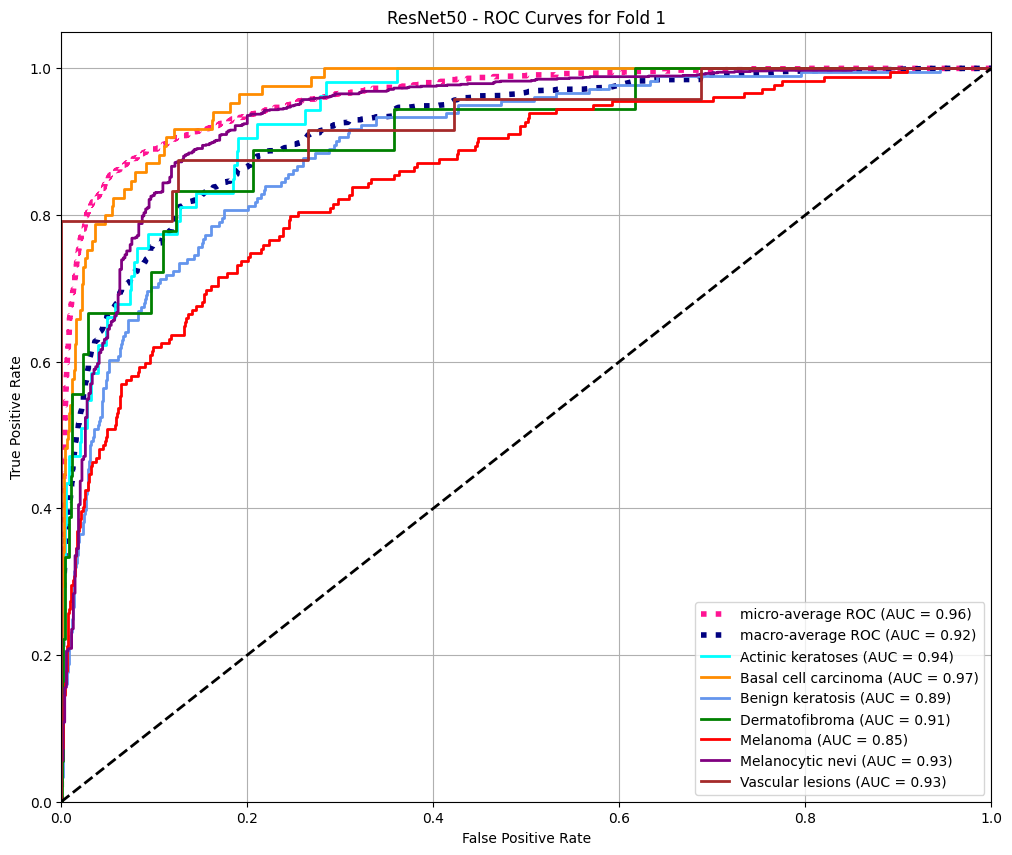


--- Fold 2 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 132s 357ms/step - accuracy: 0.6708 - auc: 0.9101 - loss: 4.0795 - val_accuracy: 0.6810 - val_auc: 0.8139 - val_loss: 1081.1276 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 231ms/step - accuracy: 0.7215 - auc: 0.9460 - loss: 1.1654 - val_accuracy: 0.6810 - val_auc: 0.8310 - val_loss: 1.3676 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 232ms/step - accuracy: 0.7616 - auc: 0.9598 - loss: 0.8410 - val_accuracy: 0.6810 - val_auc: 0.8925 - val_loss: 1.3890 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7710 - auc: 0.9657 - loss: 0.7465
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
212/212 ━━━━━━━━━━━━━━━━━━━━ 50s 234ms/step - accuracy: 0.7710 - auc: 0.9657 - loss: 0.7465 - val_accuracy: 0.6757 - val_auc: 0.8769 - val_loss: 1.2444 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 232ms/step - accuracy: 0.7979 - auc: 

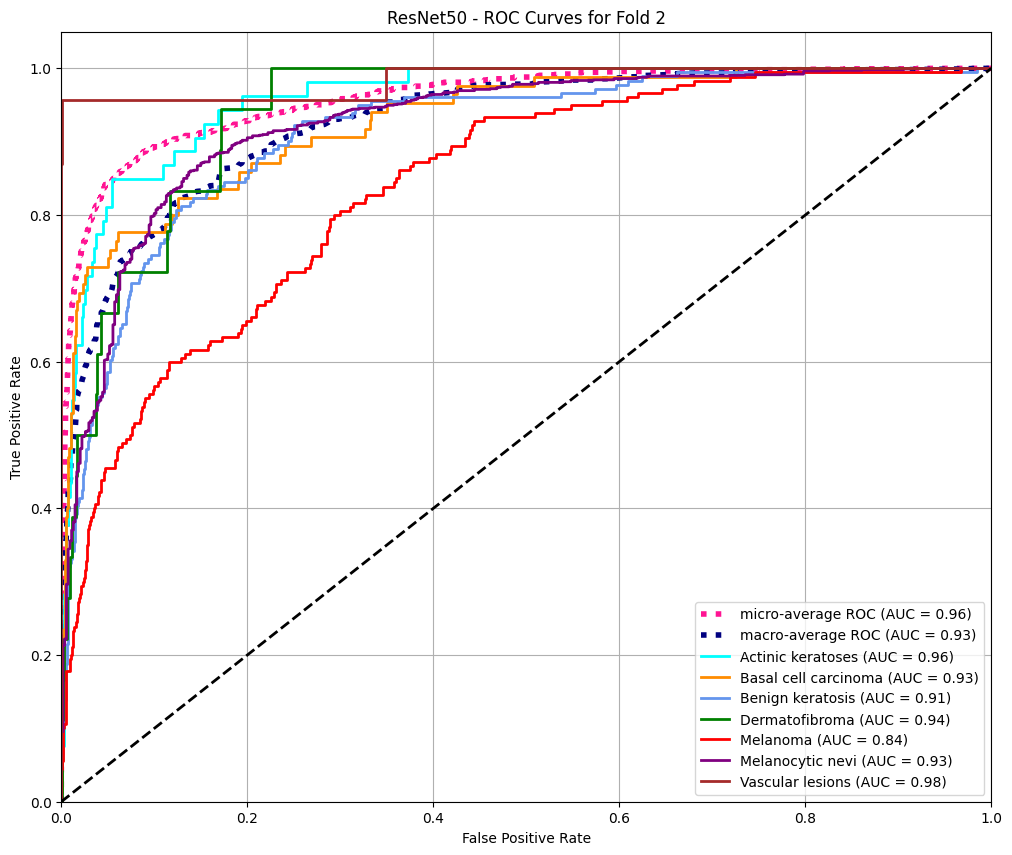


--- Fold 3 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 132s 357ms/step - accuracy: 0.6579 - auc: 0.9052 - loss: 4.0335 - val_accuracy: 0.6810 - val_auc: 0.8231 - val_loss: 2.1784 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 232ms/step - accuracy: 0.7424 - auc: 0.9516 - loss: 1.0811 - val_accuracy: 0.6810 - val_auc: 0.8764 - val_loss: 1.3598 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 50s 235ms/step - accuracy: 0.7558 - auc: 0.9603 - loss: 0.8342 - val_accuracy: 0.6810 - val_auc: 0.8491 - val_loss: 1.3680 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 50s 234ms/step - accuracy: 0.7795 - auc: 0.9681 - loss: 0.7351 - val_accuracy: 0.6846 - val_auc: 0.9127 - val_loss: 1.2401 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 48s 228ms/step - accuracy: 0.7885 - auc: 0.9702 - loss: 0.6951 - val_accuracy: 0.6633 - val_auc: 0.9168 - val_loss: 1.1026 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 230ms/step - accurac

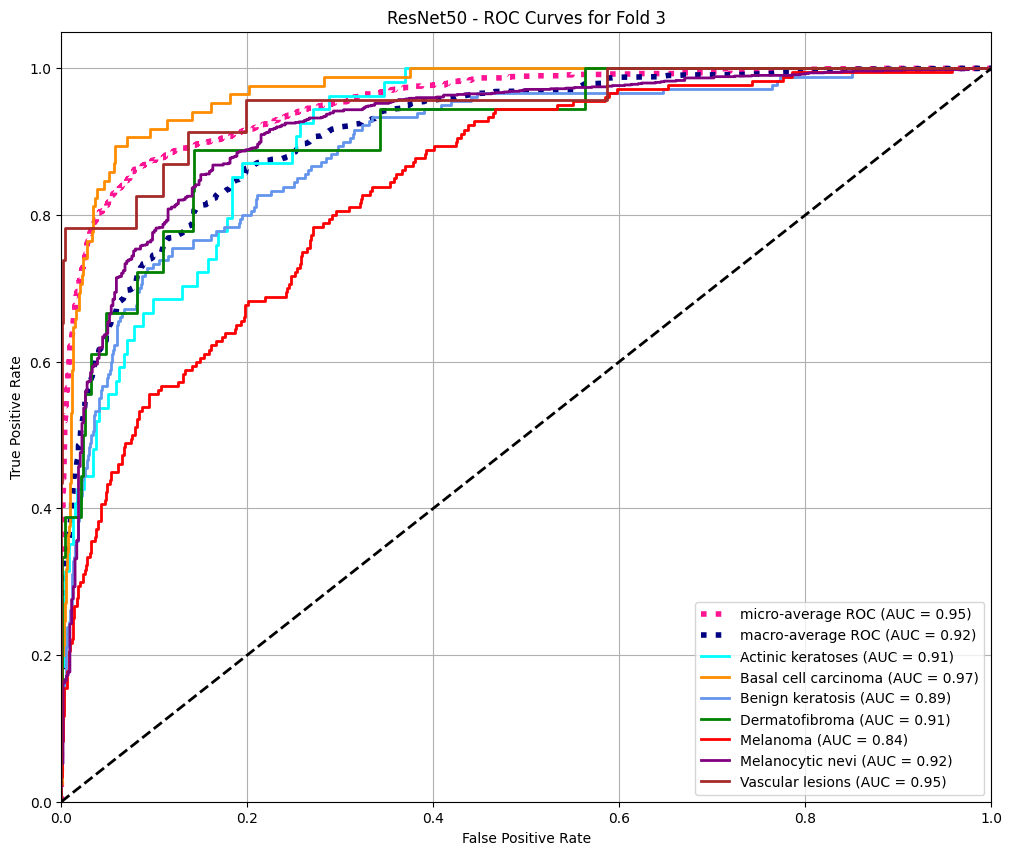


--- Fold 4 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 132s 361ms/step - accuracy: 0.6726 - auc: 0.9095 - loss: 3.9506 - val_accuracy: 0.6804 - val_auc: 0.8136 - val_loss: 1791.1378 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 231ms/step - accuracy: 0.7317 - auc: 0.9516 - loss: 1.0765 - val_accuracy: 0.6804 - val_auc: 0.8871 - val_loss: 1.4897 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 233ms/step - accuracy: 0.7270 - auc: 0.9505 - loss: 0.9596 - val_accuracy: 0.0502 - val_auc: 0.7071 - val_loss: 2.4665 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7466 - auc: 0.9572 - loss: 0.8371
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
212/212 ━━━━━━━━━━━━━━━━━━━━ 50s 234ms/step - accuracy: 0.7466 - auc: 0.9572 - loss: 0.8370 - val_accuracy: 0.6740 - val_auc: 0.8677 - val_loss: 1.4665 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 230ms/step - accuracy: 0.7675 - auc: 

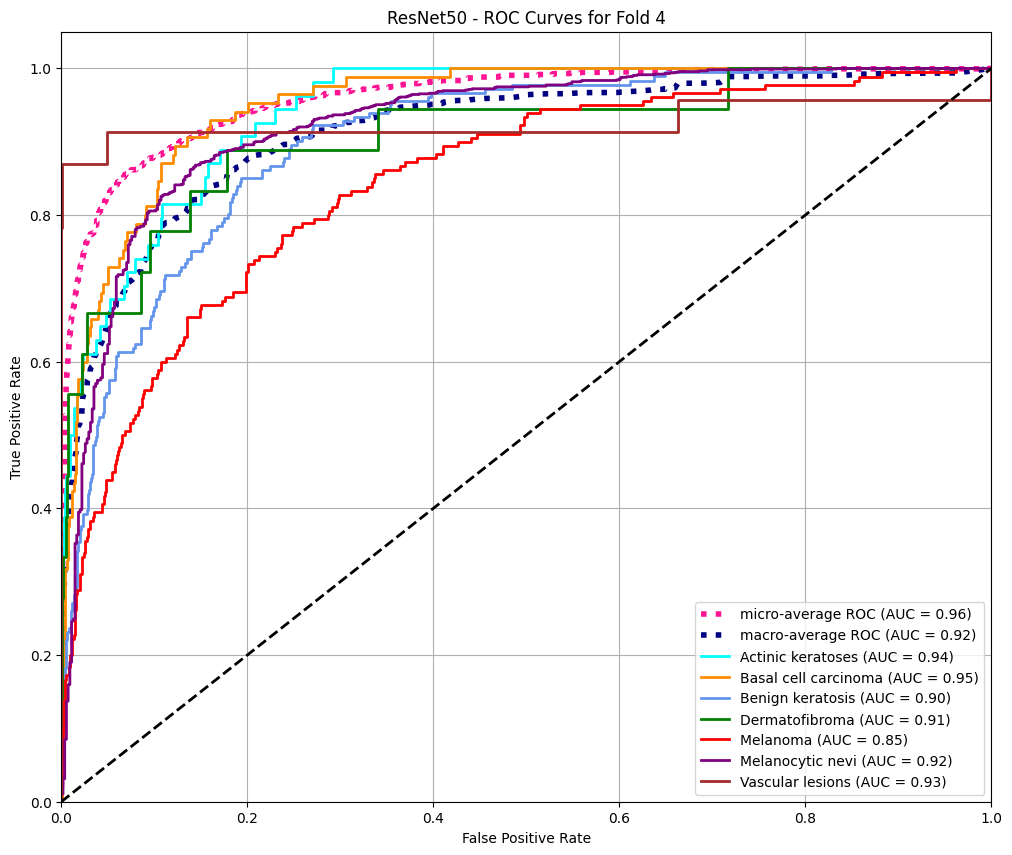


--- Fold 5 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6772 samples
Found 6772 validated image filenames belonging to 7 classes.
Found 1692 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 135s 377ms/step - accuracy: 0.6586 - auc: 0.9144 - loss: 3.9907 - val_accuracy: 0.6809 - val_auc: 0.8547 - val_loss: 1.5985 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 229ms/step - accuracy: 0.7383 - auc: 0.9516 - loss: 1.0550 - val_accuracy: 0.6809 - val_auc: 0.8612 - val_loss: 1.6172 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 232ms/step - accuracy: 0.7663 - auc: 0.9628 - loss: 0.7932 - val_accuracy: 0.6797 - val_auc: 0.9085 - val_loss: 1.2051 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 230ms/step - accuracy: 0.7703 - auc: 0.9633 - loss: 0.7783 - val_accuracy: 0.6814 - val_auc: 0.8949 - val_loss: 1.3547 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 49s 232ms/step - accuracy: 0.8052 - auc: 0.9722 - loss: 0.6682 - val_accuracy: 0.7157 - val_auc: 0.9505 - val_loss: 0.8817 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 50s 235ms/step - accurac

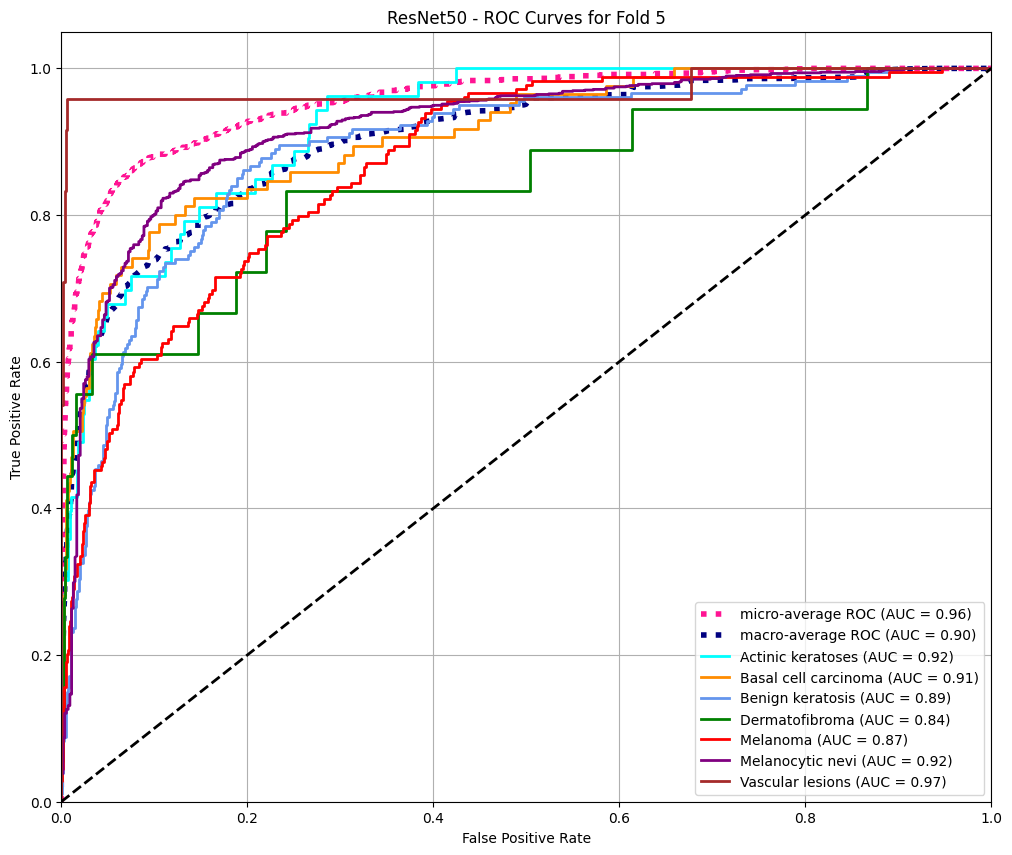


Model ResNet50 - CV Validation Accuracies for each fold: [0.8098050951957703, 0.7968103885650635, 0.7873597145080566, 0.7796810269355774, 0.7813238501548767]
Model ResNet50 - Mean Validation Accuracy: 0.7910
Model ResNet50 - CV Validation AUC for each fold: [0.9376729726791382, 0.9358032941818237, 0.931057870388031, 0.9313808679580688, 0.9347256422042847]
Model ResNet50 - Mean Validation AUC: 0.9341


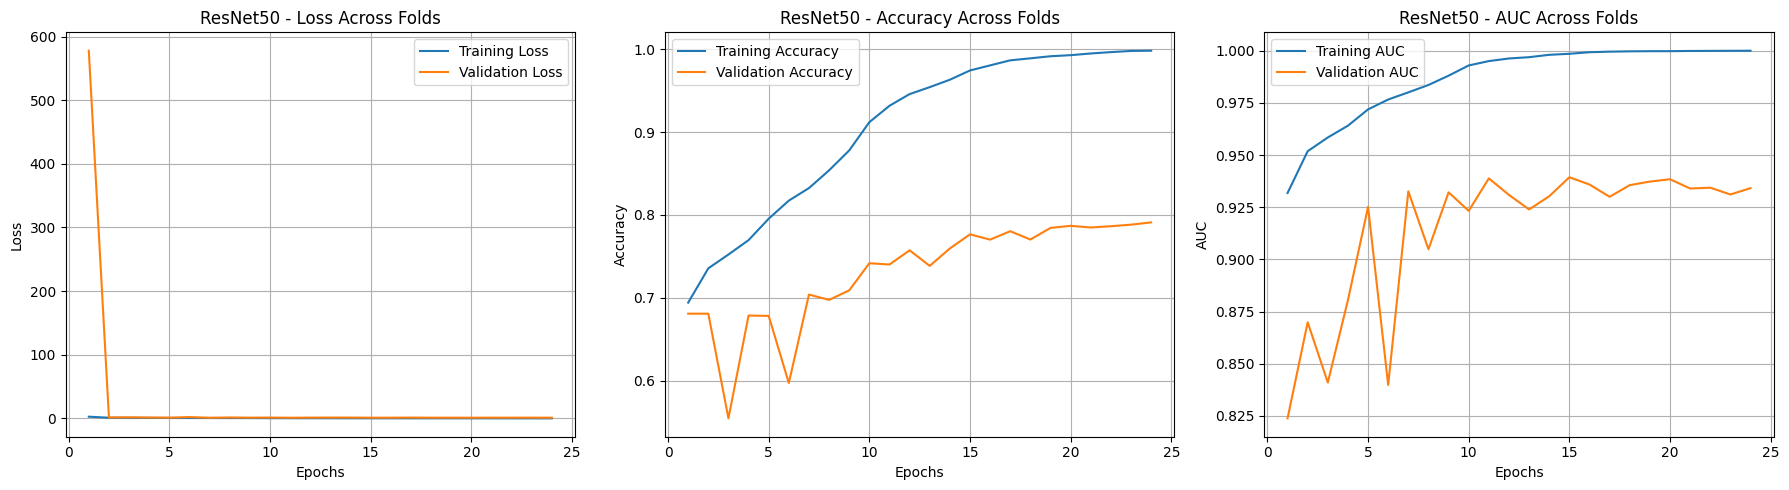


Starting 5-Fold CV for model: DenseNet201

--- Fold 1 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       983,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,374,663 (73.91 MB)

 Trainable params: 1,051,399 (4.01 MB)

 Non-trainable params: 18,323,264 (69.90 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 167s 559ms/step - accuracy: 0.3049 - auc: 0.6407 - loss: 2.8541 - val_accuracy: 0.7082 - val_auc: 0.9305 - val_loss: 0.8872 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 250ms/step - accuracy: 0.5879 - auc: 0.8455 - loss: 1.4569 - val_accuracy: 0.7242 - val_auc: 0.9423 - val_loss: 0.8196 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 251ms/step - accuracy: 0.6501 - auc: 0.8903 - loss: 1.1475 - val_accuracy: 0.7336 - val_auc: 0.9511 - val_loss: 0.7622 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 249ms/step - accuracy: 0.6754 - auc: 0.9149 - loss: 0.9938 - val_accuracy: 0.7342 - val_auc: 0.9539 - val_loss: 0.7399 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 249ms/step - accuracy: 0.6885 - auc: 0.9263 - loss: 0.9260 - val_accuracy: 0.7377 - val_auc: 0.9552 - val_loss: 0.7320 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 252ms/step - accurac

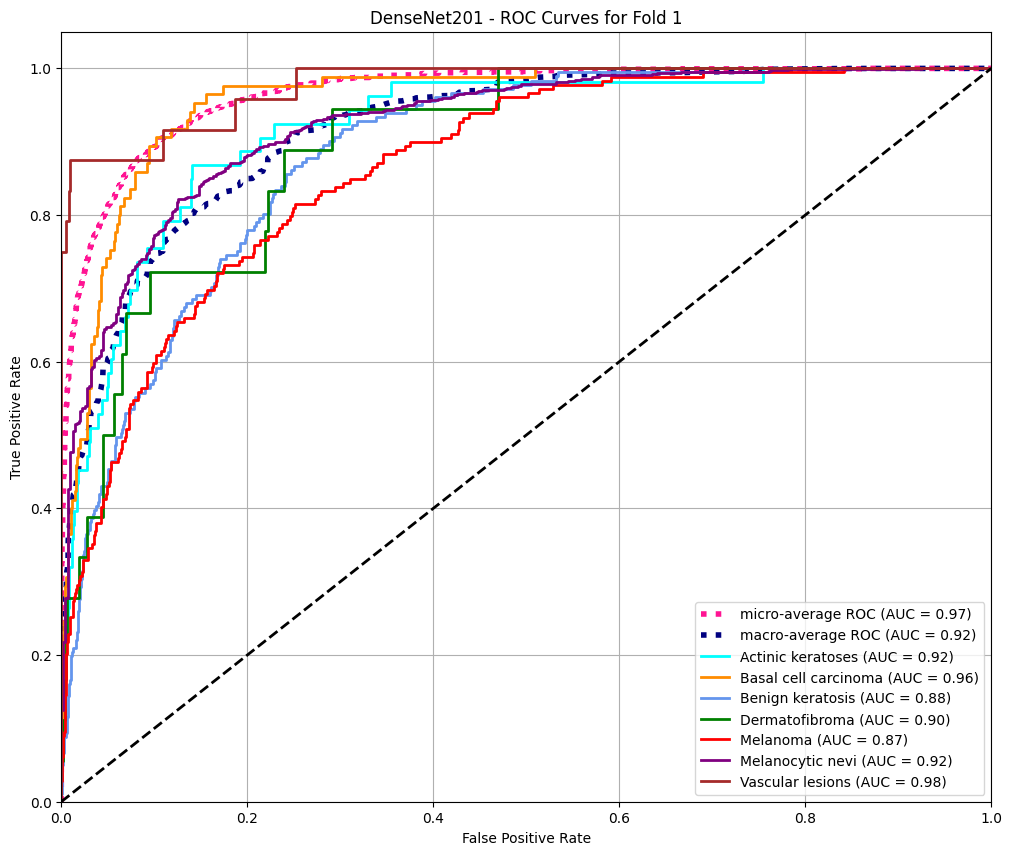


--- Fold 2 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 145s 492ms/step - accuracy: 0.2853 - auc: 0.6280 - loss: 2.8869 - val_accuracy: 0.6917 - val_auc: 0.9141 - val_loss: 1.0175 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 250ms/step - accuracy: 0.6034 - auc: 0.8484 - loss: 1.4462 - val_accuracy: 0.7194 - val_auc: 0.9407 - val_loss: 0.8278 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 55s 258ms/step - accuracy: 0.6578 - auc: 0.8922 - loss: 1.1465 - val_accuracy: 0.7194 - val_auc: 0.9497 - val_loss: 0.7723 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 252ms/step - accuracy: 0.6753 - auc: 0.9150 - loss: 0.9969 - val_accuracy: 0.7318 - val_auc: 0.9519 - val_loss: 0.7563 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 248ms/step - accuracy: 0.6907 - auc: 0.9240 - loss: 0.9391 - val_accuracy: 0.7336 - val_auc: 0.9541 - val_loss: 0.7375 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 251ms/step - accurac

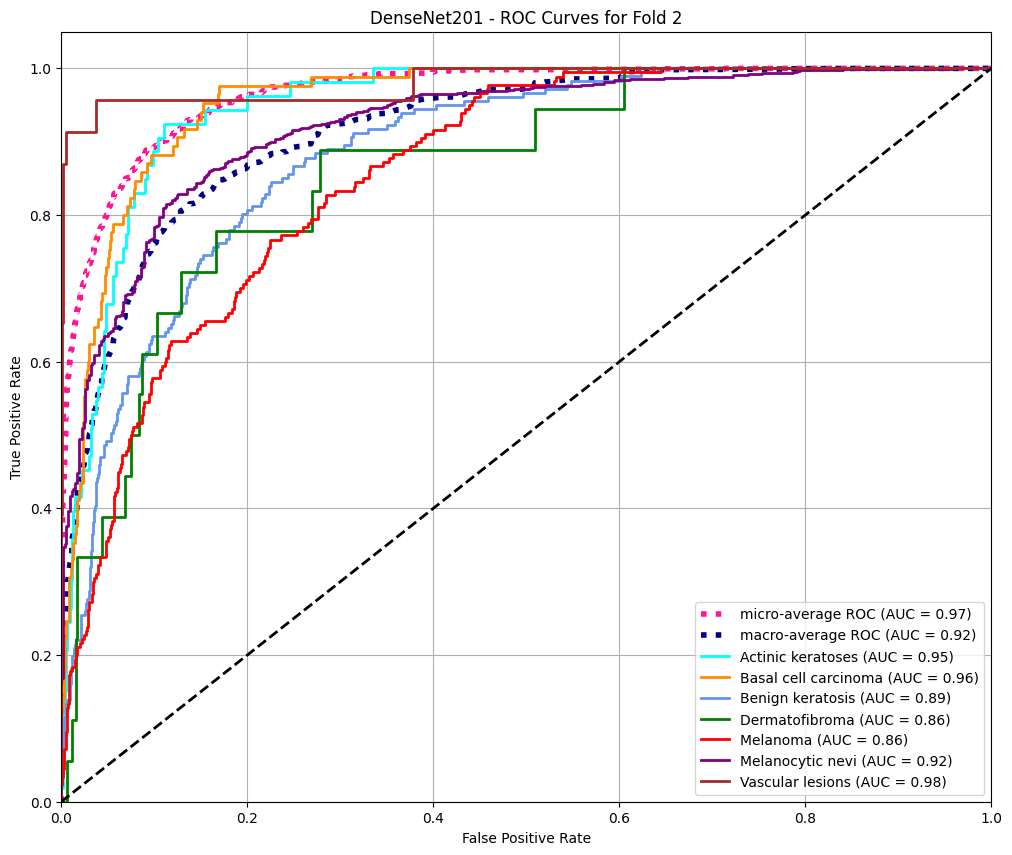


--- Fold 3 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 141s 471ms/step - accuracy: 0.2795 - auc: 0.6222 - loss: 2.8622 - val_accuracy: 0.6905 - val_auc: 0.9164 - val_loss: 0.9796 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 248ms/step - accuracy: 0.5826 - auc: 0.8343 - loss: 1.4805 - val_accuracy: 0.7259 - val_auc: 0.9475 - val_loss: 0.7932 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 55s 258ms/step - accuracy: 0.6636 - auc: 0.8952 - loss: 1.1134 - val_accuracy: 0.7324 - val_auc: 0.9537 - val_loss: 0.7560 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 249ms/step - accuracy: 0.6866 - auc: 0.9172 - loss: 0.9762 - val_accuracy: 0.7407 - val_auc: 0.9573 - val_loss: 0.7347 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 250ms/step - accuracy: 0.6866 - auc: 0.9269 - loss: 0.9230 - val_accuracy: 0.7342 - val_auc: 0.9567 - val_loss: 0.7316 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 251ms/step - accurac

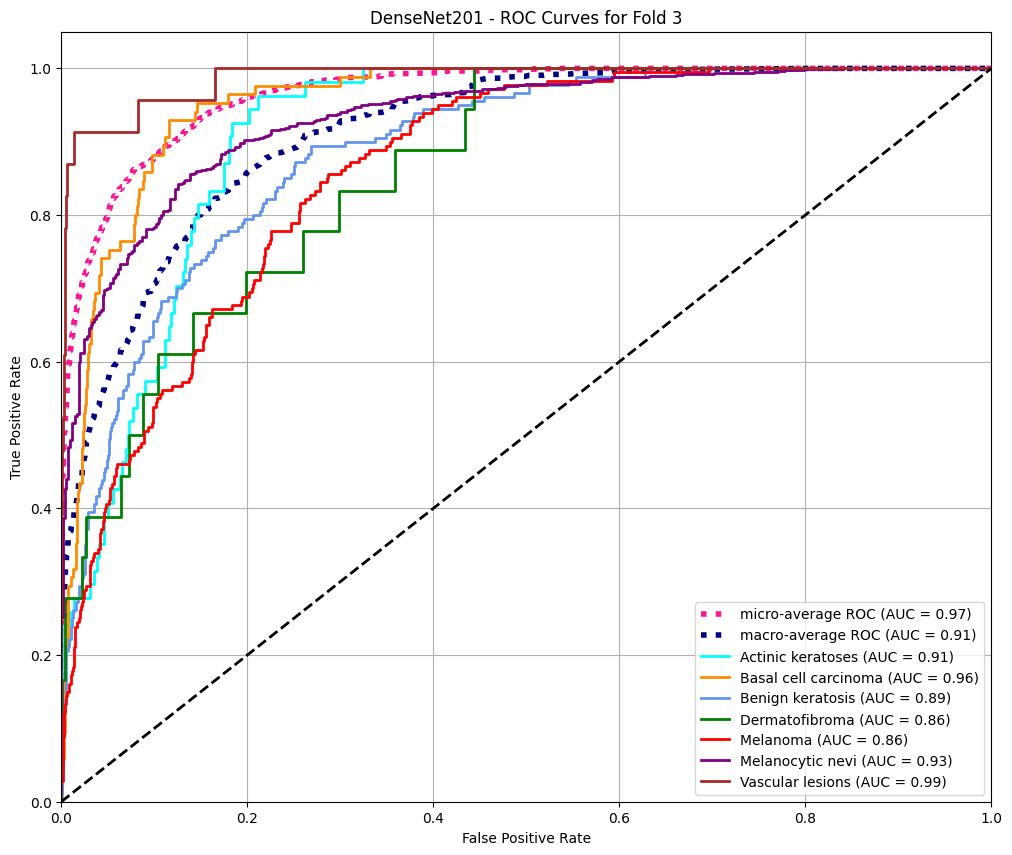


--- Fold 4 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 139s 472ms/step - accuracy: 0.2991 - auc: 0.6348 - loss: 2.7947 - val_accuracy: 0.7141 - val_auc: 0.9354 - val_loss: 0.8713 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 250ms/step - accuracy: 0.5940 - auc: 0.8439 - loss: 1.4314 - val_accuracy: 0.7354 - val_auc: 0.9473 - val_loss: 0.7828 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 250ms/step - accuracy: 0.6533 - auc: 0.8948 - loss: 1.1142 - val_accuracy: 0.7377 - val_auc: 0.9531 - val_loss: 0.7501 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 248ms/step - accuracy: 0.6705 - auc: 0.9112 - loss: 1.0182 - val_accuracy: 0.7283 - val_auc: 0.9543 - val_loss: 0.7439 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 247ms/step - accuracy: 0.6856 - auc: 0.9264 - loss: 0.9241 - val_accuracy: 0.7383 - val_auc: 0.9568 - val_loss: 0.7231 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 250ms/step - accurac

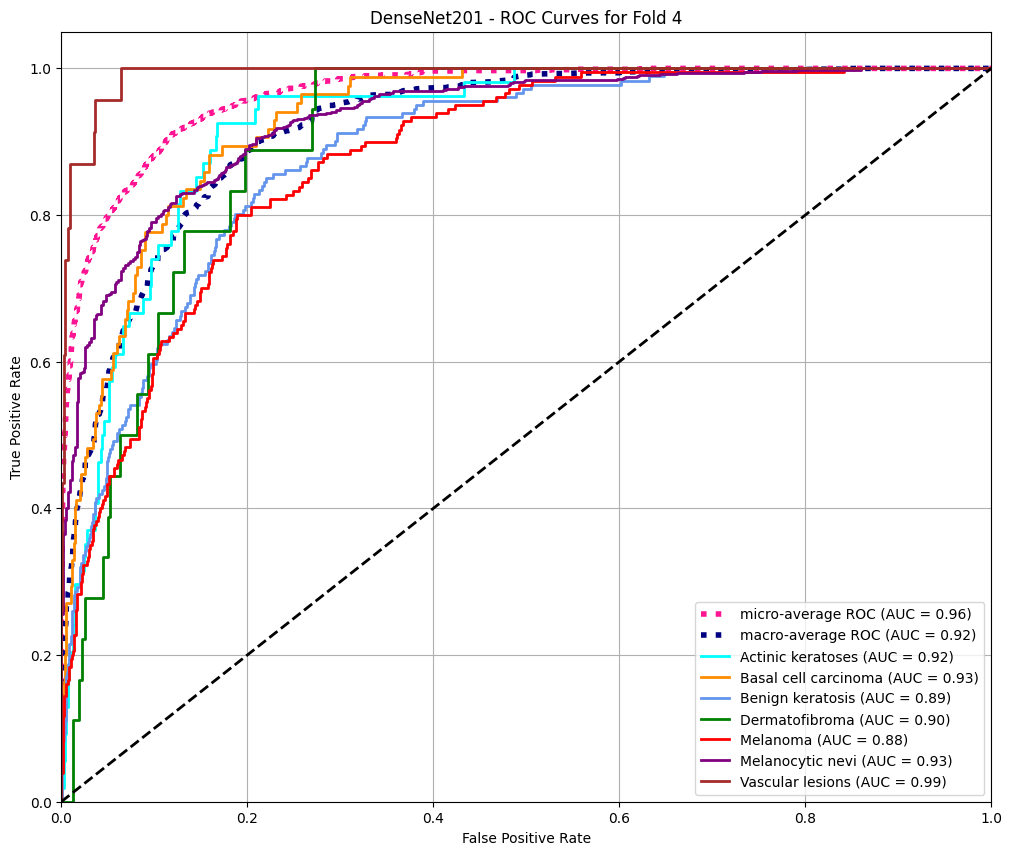


--- Fold 5 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6772 samples
Found 6772 validated image filenames belonging to 7 classes.
Found 1692 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 157s 553ms/step - accuracy: 0.2807 - auc: 0.6248 - loss: 2.9316 - val_accuracy: 0.6844 - val_auc: 0.9135 - val_loss: 1.0081 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 52s 247ms/step - accuracy: 0.5834 - auc: 0.8478 - loss: 1.4273 - val_accuracy: 0.7252 - val_auc: 0.9474 - val_loss: 0.7884 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 52s 246ms/step - accuracy: 0.6567 - auc: 0.8990 - loss: 1.1081 - val_accuracy: 0.7234 - val_auc: 0.9500 - val_loss: 0.7713 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 248ms/step - accuracy: 0.6832 - auc: 0.9202 - loss: 0.9654 - val_accuracy: 0.7299 - val_auc: 0.9539 - val_loss: 0.7462 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 249ms/step - accuracy: 0.6904 - auc: 0.9289 - loss: 0.9099 - val_accuracy: 0.7287 - val_auc: 0.9545 - val_loss: 0.7423 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 251ms/step - accurac

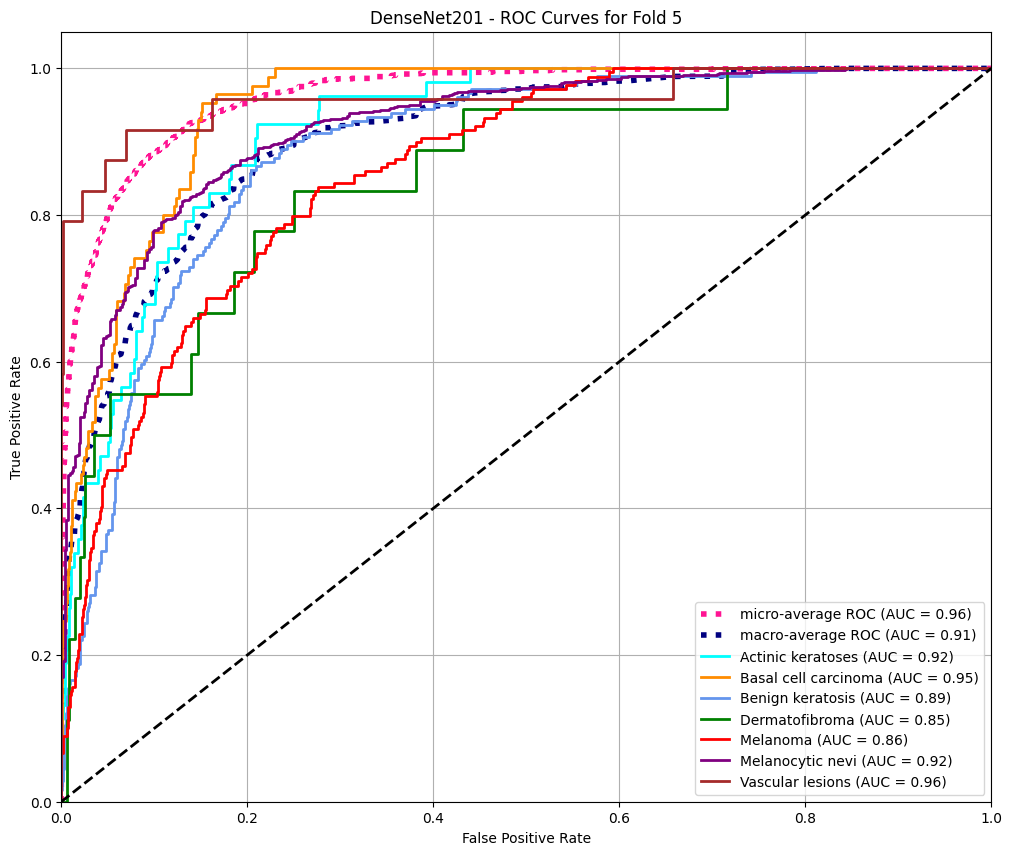


Model DenseNet201 - CV Validation Accuracies for each fold: [0.7690490484237671, 0.764914333820343, 0.7702303528785706, 0.7631423473358154, 0.7547281384468079]
Model DenseNet201 - Mean Validation Accuracy: 0.7644
Model DenseNet201 - CV Validation AUC for each fold: [0.9653441309928894, 0.9661825895309448, 0.9652841687202454, 0.964399516582489, 0.9634458422660828]
Model DenseNet201 - Mean Validation AUC: 0.9649


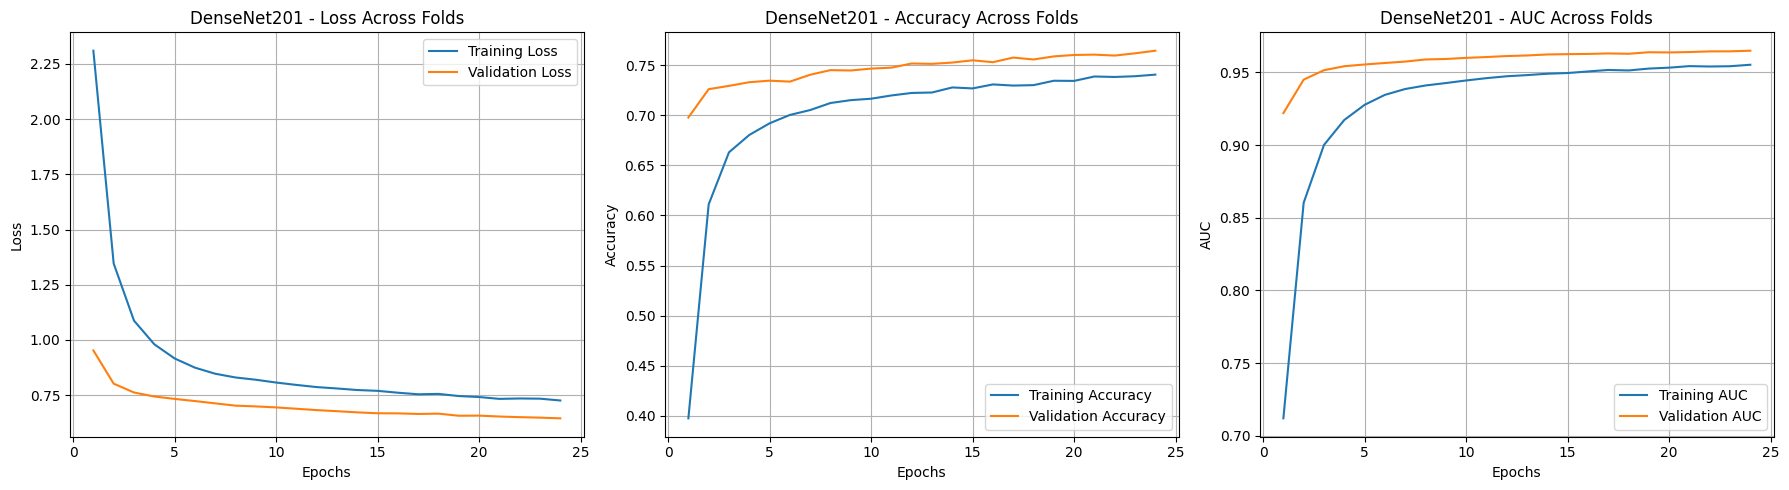


Starting 5-Fold CV for model: EfficientNetB3

--- Fold 1 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,639,606 (44.40 MB)

 Trainable params: 854,791 (3.26 MB)

 Non-trainable params: 10,784,815 (41.14 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 144s 483ms/step - accuracy: 0.3104 - auc: 0.6540 - loss: 2.7737 - val_accuracy: 0.7194 - val_auc: 0.9328 - val_loss: 0.8721 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 59s 276ms/step - accuracy: 0.5912 - auc: 0.8511 - loss: 1.4177 - val_accuracy: 0.7218 - val_auc: 0.9463 - val_loss: 0.7954 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 62s 292ms/step - accuracy: 0.6687 - auc: 0.9050 - loss: 1.0681 - val_accuracy: 0.7242 - val_auc: 0.9506 - val_loss: 0.7696 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 61s 286ms/step - accuracy: 0.6832 - auc: 0.9207 - loss: 0.9630 - val_accuracy: 0.7289 - val_auc: 0.9560 - val_loss: 0.7295 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 273ms/step - accuracy: 0.6997 - auc: 0.9314 - loss: 0.8913 - val_accuracy: 0.7318 - val_auc: 0.9570 - val_loss: 0.7186 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 272ms/step - accurac

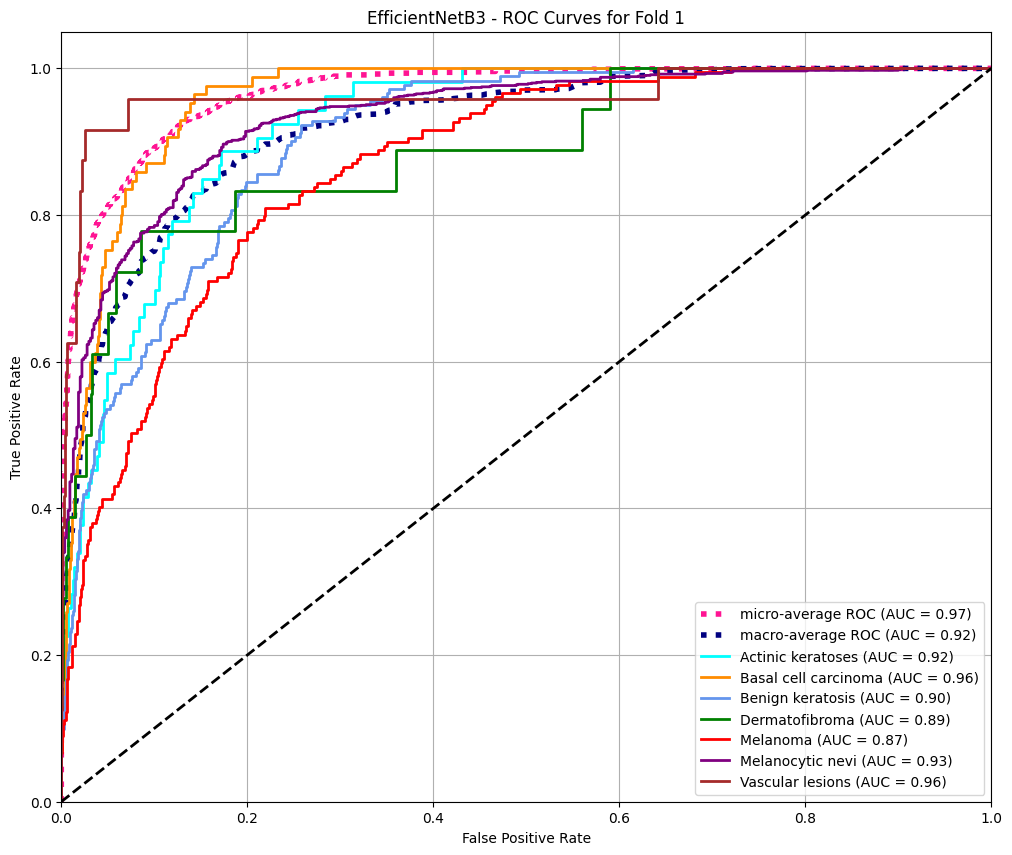


--- Fold 2 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 124s 417ms/step - accuracy: 0.3002 - auc: 0.6347 - loss: 2.8935 - val_accuracy: 0.7112 - val_auc: 0.9237 - val_loss: 0.9269 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 274ms/step - accuracy: 0.5985 - auc: 0.8533 - loss: 1.3980 - val_accuracy: 0.7330 - val_auc: 0.9476 - val_loss: 0.7850 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 60s 285ms/step - accuracy: 0.6837 - auc: 0.9074 - loss: 1.0518 - val_accuracy: 0.7383 - val_auc: 0.9527 - val_loss: 0.7462 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 60s 282ms/step - accuracy: 0.6985 - auc: 0.9237 - loss: 0.9367 - val_accuracy: 0.7377 - val_auc: 0.9555 - val_loss: 0.7287 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 276ms/step - accuracy: 0.7087 - auc: 0.9343 - loss: 0.8752 - val_accuracy: 0.7377 - val_auc: 0.9569 - val_loss: 0.7167 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 272ms/step - accurac

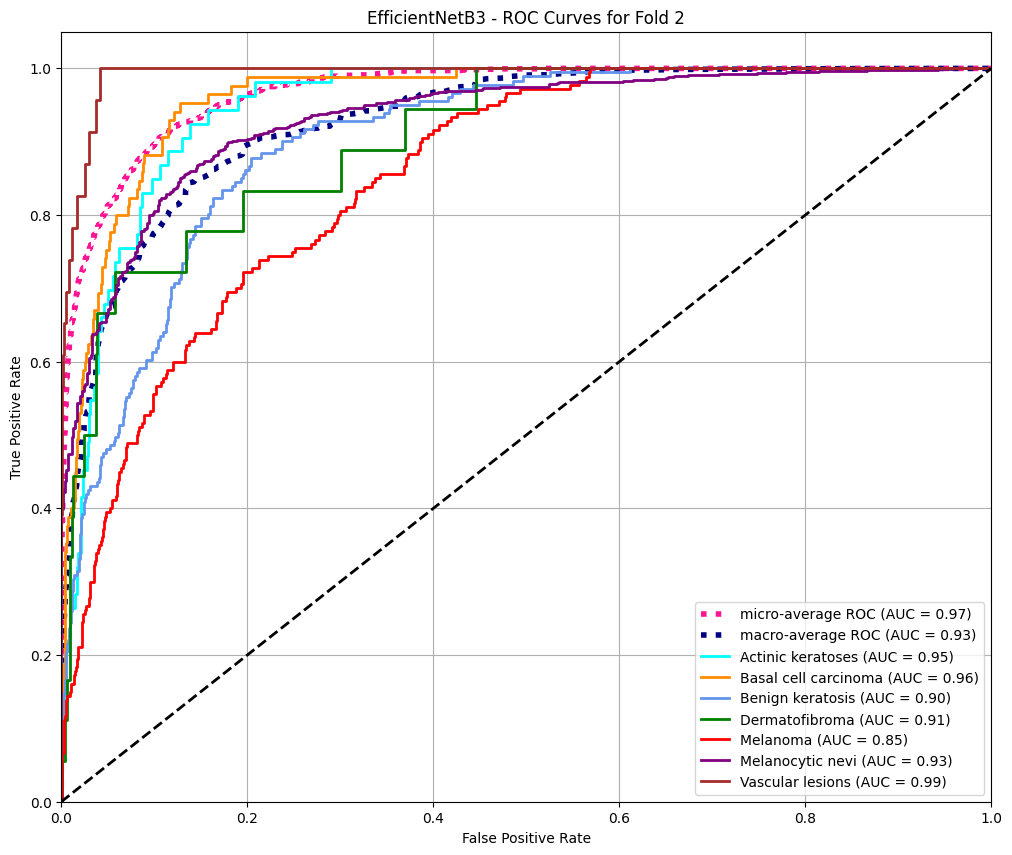


--- Fold 3 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 124s 420ms/step - accuracy: 0.3341 - auc: 0.6617 - loss: 2.7796 - val_accuracy: 0.7153 - val_auc: 0.9323 - val_loss: 0.8844 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 272ms/step - accuracy: 0.6017 - auc: 0.8586 - loss: 1.3745 - val_accuracy: 0.7236 - val_auc: 0.9449 - val_loss: 0.8131 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 59s 278ms/step - accuracy: 0.6575 - auc: 0.8987 - loss: 1.0978 - val_accuracy: 0.7348 - val_auc: 0.9500 - val_loss: 0.7693 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 274ms/step - accuracy: 0.7007 - auc: 0.9216 - loss: 0.9497 - val_accuracy: 0.7348 - val_auc: 0.9532 - val_loss: 0.7453 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 59s 276ms/step - accuracy: 0.6917 - auc: 0.9280 - loss: 0.9174 - val_accuracy: 0.7448 - val_auc: 0.9560 - val_loss: 0.7286 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 275ms/step - accurac

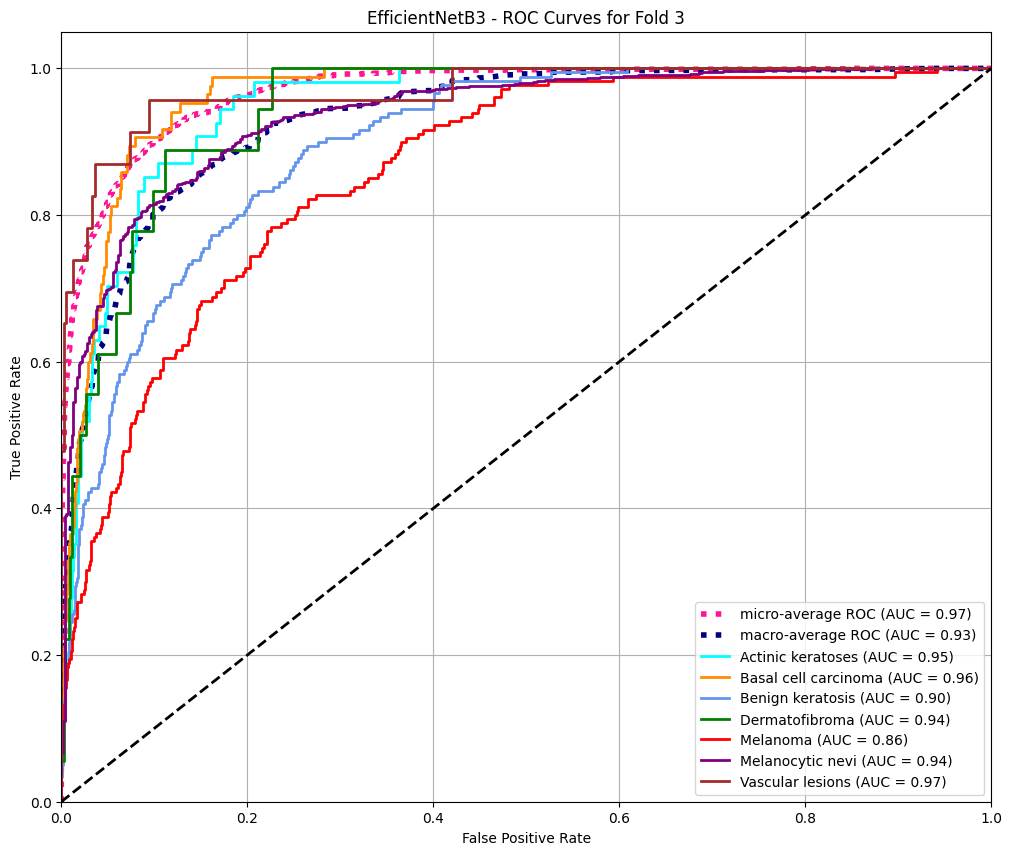


--- Fold 4 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Found 6771 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 127s 430ms/step - accuracy: 0.3347 - auc: 0.6640 - loss: 2.7206 - val_accuracy: 0.7348 - val_auc: 0.9395 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 274ms/step - accuracy: 0.6090 - auc: 0.8599 - loss: 1.3669 - val_accuracy: 0.7525 - val_auc: 0.9495 - val_loss: 0.7655 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 61s 287ms/step - accuracy: 0.6628 - auc: 0.9039 - loss: 1.0722 - val_accuracy: 0.7472 - val_auc: 0.9547 - val_loss: 0.7312 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 59s 278ms/step - accuracy: 0.6890 - auc: 0.9245 - loss: 0.9354 - val_accuracy: 0.7431 - val_auc: 0.9567 - val_loss: 0.7175 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7052 - auc: 0.9323 - loss: 0.8839
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 275ms/step - accuracy: 0.7052 - auc: 0.9

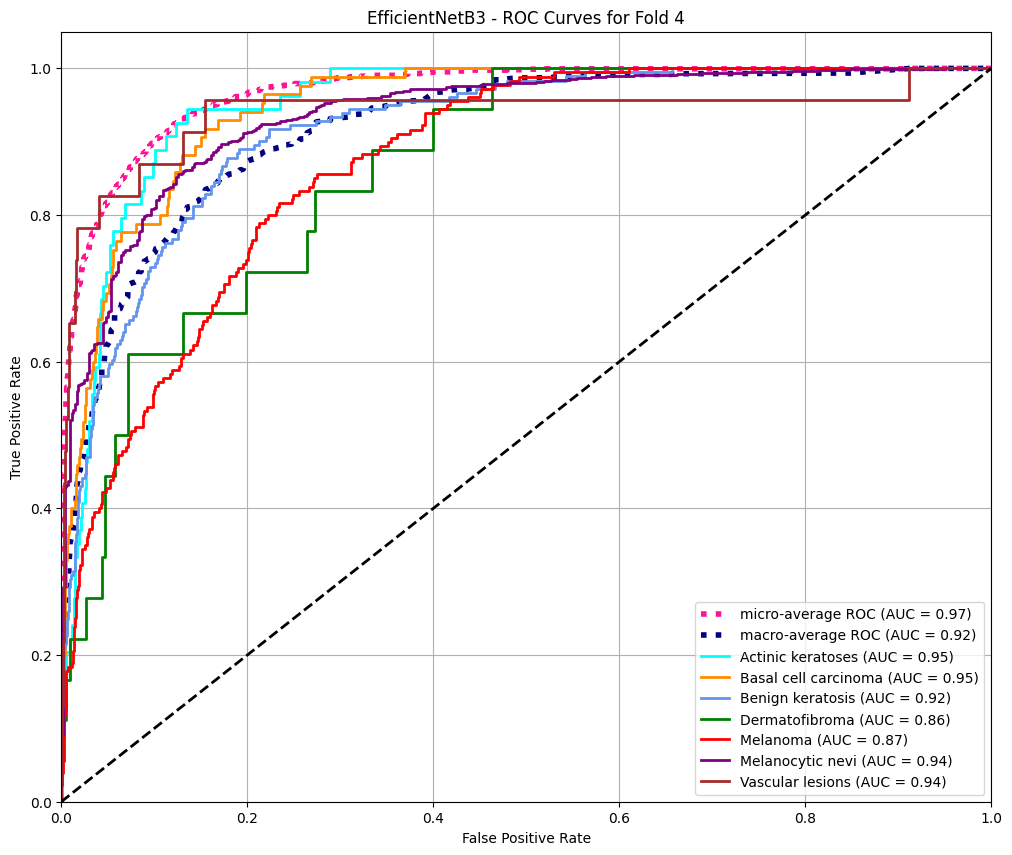


--- Fold 5 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6772 samples
Found 6772 validated image filenames belonging to 7 classes.
Found 1692 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 137s 484ms/step - accuracy: 0.3277 - auc: 0.6667 - loss: 2.7364 - val_accuracy: 0.6950 - val_auc: 0.9299 - val_loss: 0.9029 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 59s 280ms/step - accuracy: 0.6006 - auc: 0.8631 - loss: 1.3632 - val_accuracy: 0.7311 - val_auc: 0.9484 - val_loss: 0.7850 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 61s 288ms/step - accuracy: 0.6735 - auc: 0.9059 - loss: 1.0561 - val_accuracy: 0.7340 - val_auc: 0.9520 - val_loss: 0.7561 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 57s 271ms/step - accuracy: 0.6817 - auc: 0.9228 - loss: 0.9511 - val_accuracy: 0.7329 - val_auc: 0.9543 - val_loss: 0.7380 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 274ms/step - accuracy: 0.6895 - auc: 0.9290 - loss: 0.9117 - val_accuracy: 0.7394 - val_auc: 0.9559 - val_loss: 0.7277 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 58s 273ms/step - accurac

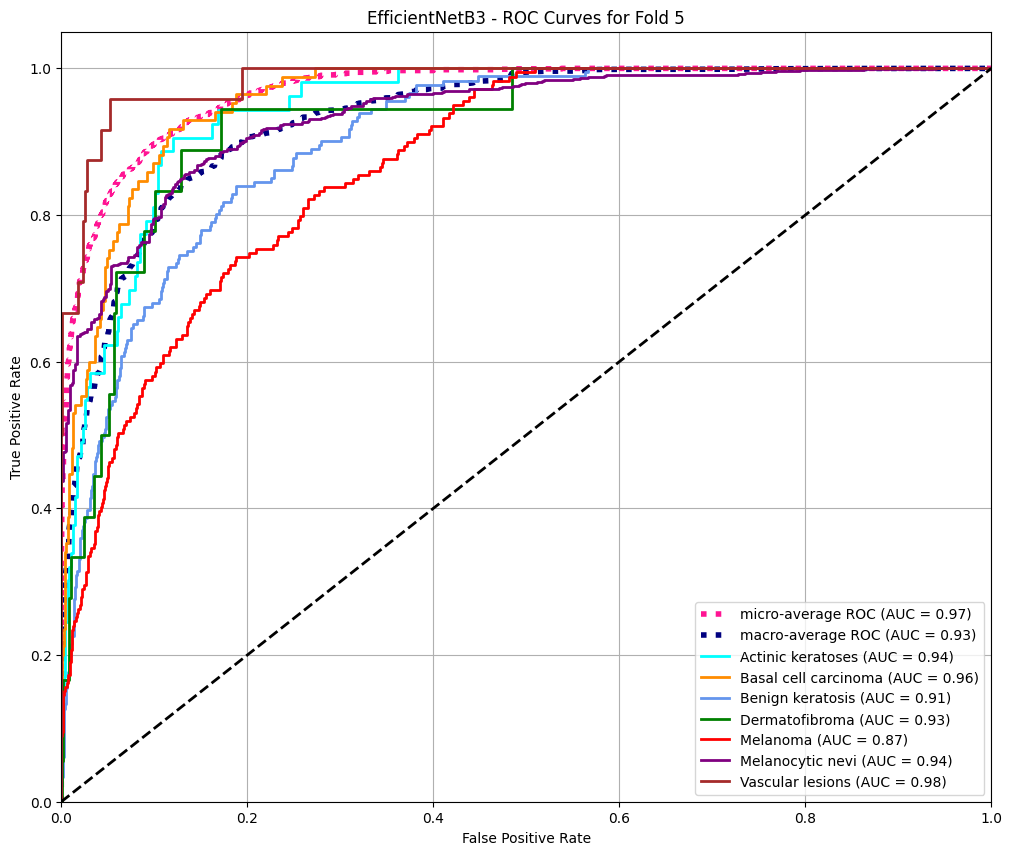


Model EfficientNetB3 - CV Validation Accuracies for each fold: [0.7725930213928223, 0.7714117169380188, 0.7767276763916016, 0.7826343774795532, 0.7760047316551208]
Model EfficientNetB3 - Mean Validation Accuracy: 0.7759
Model EfficientNetB3 - CV Validation AUC for each fold: [0.9667454361915588, 0.9683264493942261, 0.968877375125885, 0.9682230353355408, 0.9689520001411438]
Model EfficientNetB3 - Mean Validation AUC: 0.9682


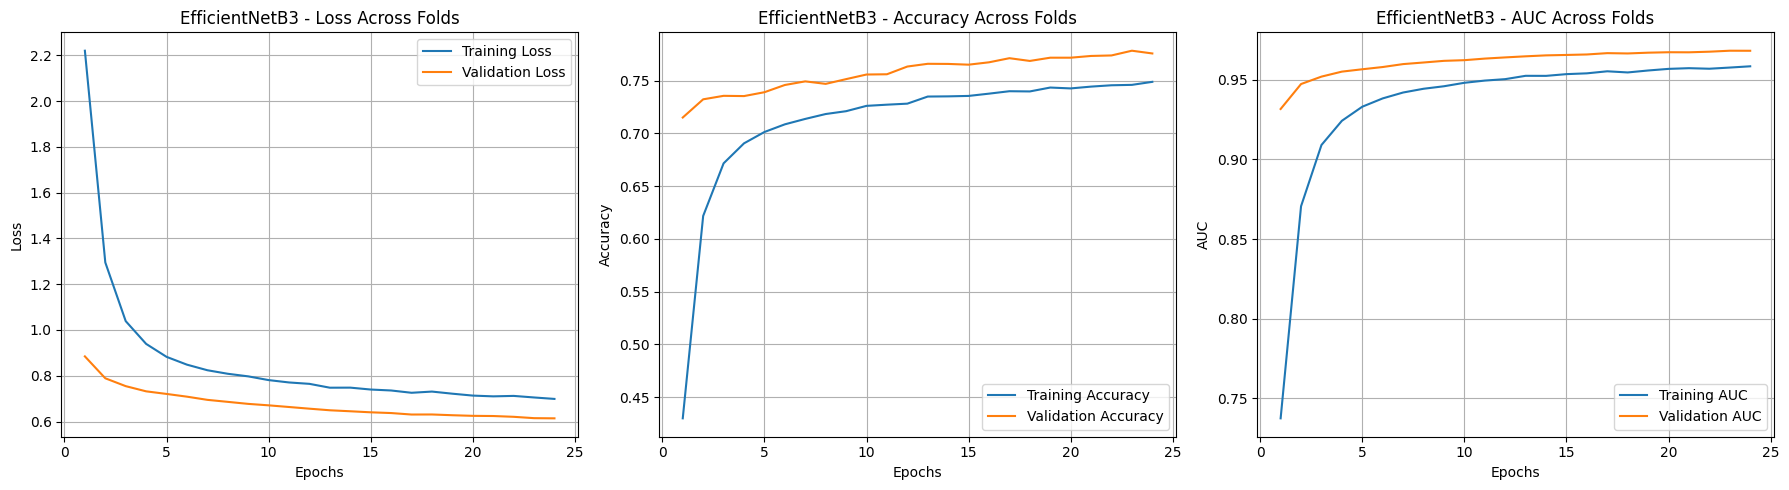

In [7]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
num_epochs = 24
batch_size = 32

for model_name, config in model_configs.items():
    print("\n================================================")
    print(f"Starting {num_folds}-Fold CV for model: {model_name}")
    print("================================================")

    img_size = config["img_size"]
    use_rescale = config["use_rescale"]
    model_func = config["model_func"]

    fold_no = 1
    acc_per_fold = []
    loss_per_fold = []
    auc_per_fold = []
    val_loss_histories = []
    val_acc_histories = []
    val_auc_histories = []
    train_loss_histories = []
    train_acc_histories = []
    train_auc_histories = []

    roc_curves = {'fold': [], 'fpr': [], 'tpr': [], 'roc_auc': []}

    for train_index, val_index in skf.split(df_train, df_train['label_numeric']):
        print(f"\n--- Fold {fold_no} ---")
        train_data = df_train.iloc[train_index]
        val_data = df_train.iloc[val_index]

        print("\nBalancing training data...")
        balanced_train_data = balance_data(train_data, oversample=USE_AUGMENTATION_AND_OVERSAMPLING)
        print(f"Final balanced training set size: {len(balanced_train_data)} samples")

        if use_rescale:
            train_gen_fold = tr_gen_rescale.flow_from_dataframe(
                balanced_train_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=True,
                batch_size=batch_size
            )
            valid_gen_fold = ts_gen_rescale.flow_from_dataframe(
                val_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=False,
                batch_size=batch_size
            )
        else:
            train_gen_fold = tr_gen_no_rescale.flow_from_dataframe(
                balanced_train_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=True,
                batch_size=batch_size
            )
            valid_gen_fold = ts_gen_no_rescale.flow_from_dataframe(
                val_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=False,
                batch_size=batch_size
            )

        class_indices = train_gen_fold.class_indices
        class_names = list(class_indices.keys())

        model = model_func(input_shape=(img_size[0], img_size[1], 3), num_classes=len(class_indices))
        model = compile_model(model)

        if fold_no == 1:
            model.summary()

        history = model.fit(
            train_gen_fold,
            epochs=num_epochs,
            validation_data=valid_gen_fold,
            callbacks=[learning_rate_reduction],
            verbose=1
        )

        train_loss_histories.append(history.history['loss'])
        train_acc_histories.append(history.history['accuracy'])
        train_auc_histories.append(history.history['auc'])
        val_loss_histories.append(history.history['val_loss'])
        val_acc_histories.append(history.history['val_accuracy'])
        val_auc_histories.append(history.history['val_auc'])

        fold_val_loss, fold_val_acc, fold_val_auc = model.evaluate(valid_gen_fold)
        print(f"Fold {fold_no} - Validation Loss: {fold_val_loss:.4f}, Validation Accuracy: {fold_val_acc:.4f}, Validation AUC: {fold_val_auc:.4f}")

        loss_per_fold.append(fold_val_loss)
        acc_per_fold.append(fold_val_acc)
        auc_per_fold.append(fold_val_auc)

        y_pred = model.predict(valid_gen_fold)
        y_true = np.array(valid_gen_fold.classes)
        class_names = list(valid_gen_fold.class_indices.keys())

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(len(class_indices)):
            y_true_binary = np.array(y_true == i, dtype=int)
            fpr[i], tpr[i], _ = roc_curve(
                y_true_binary,
                y_pred[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(
            tf.keras.utils.to_categorical(y_true, num_classes=len(class_indices)).ravel(),
            y_pred.ravel()
        )
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_indices))]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(class_indices)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(class_indices)
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        roc_curves['fold'].append(fold_no)
        roc_curves['fpr'].append(fpr)
        roc_curves['tpr'].append(tpr)
        roc_curves['roc_auc'].append(roc_auc)

        lesion_names = [lesion_type_dict[key] for key in class_names]
        plot_roc_curves(fpr, tpr, roc_auc, lesion_names, f"{model_name} - ROC Curves for Fold {fold_no}")

        del model
        tf.keras.backend.clear_session()
        gc.collect()

        fold_no += 1

    print(f"\nModel {model_name} - CV Validation Accuracies for each fold: {acc_per_fold}")
    print(f"Model {model_name} - Mean Validation Accuracy: {np.mean(acc_per_fold):.4f}")
    print(f"Model {model_name} - CV Validation AUC for each fold: {auc_per_fold}")
    print(f"Model {model_name} - Mean Validation AUC: {np.mean(auc_per_fold):.4f}")

    avg_train_loss = np.mean(np.array(train_loss_histories), axis=0)
    avg_train_accuracy = np.mean(np.array(train_acc_histories), axis=0)
    avg_train_auc = np.mean(np.array(train_auc_histories), axis=0)
    avg_val_loss = np.mean(np.array(val_loss_histories), axis=0)
    avg_val_accuracy = np.mean(np.array(val_acc_histories), axis=0)
    avg_val_auc = np.mean(np.array(val_auc_histories), axis=0)
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, avg_train_loss, label='Training Loss')
    plt.plot(epochs_range, avg_val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Across Folds')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, avg_train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, avg_val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy Across Folds')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, avg_train_auc, label='Training AUC')
    plt.plot(epochs_range, avg_val_auc, label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title(f'{model_name} - AUC Across Folds')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Final Training and Evaluation


Final Training and Evaluation for model: ResNet50

Balancing full training data for final model...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced full training set size: 8464 samples
Found 8464 validated image filenames belonging to 7 classes.
Found 968 validated image filenames belonging to 7 classes.

--- Final training on full training data ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 127s 267ms/step - accuracy: 0.6756 - auc: 0.9134 - loss: 3.8332 - learning_rate: 0.0010
Epoch 2/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - accuracy: 0.7155 - auc: 0.9479 - loss: 1.0650 - learning_rate: 0.0010
Epoch 3/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 50s 188ms/step - accuracy: 0.7395 - auc: 0.9576 - loss: 0.8381 - learning_rate: 0.0010
Epoch 4/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - accuracy: 0.7607 - auc: 0.9635 - loss: 0.7742 - learning_rate: 0.0010
Epoch 5/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - accuracy: 0.7754 - auc: 0.9651 - loss: 0.7420 - learning_rate: 0.0010
Epoch 6/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - accuracy: 0.7960 - auc: 0.9715 - loss: 0.6697 - learning_rate: 0.0010
Epoch 7/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 50s 188ms/step - accuracy: 0.8113 - auc: 0.9751 - loss: 0.6358 - learning_rate: 0.0010
Epoch 8/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - accuracy: 0.8157 - auc: 0.9754 - loss: 0.6310 - learn

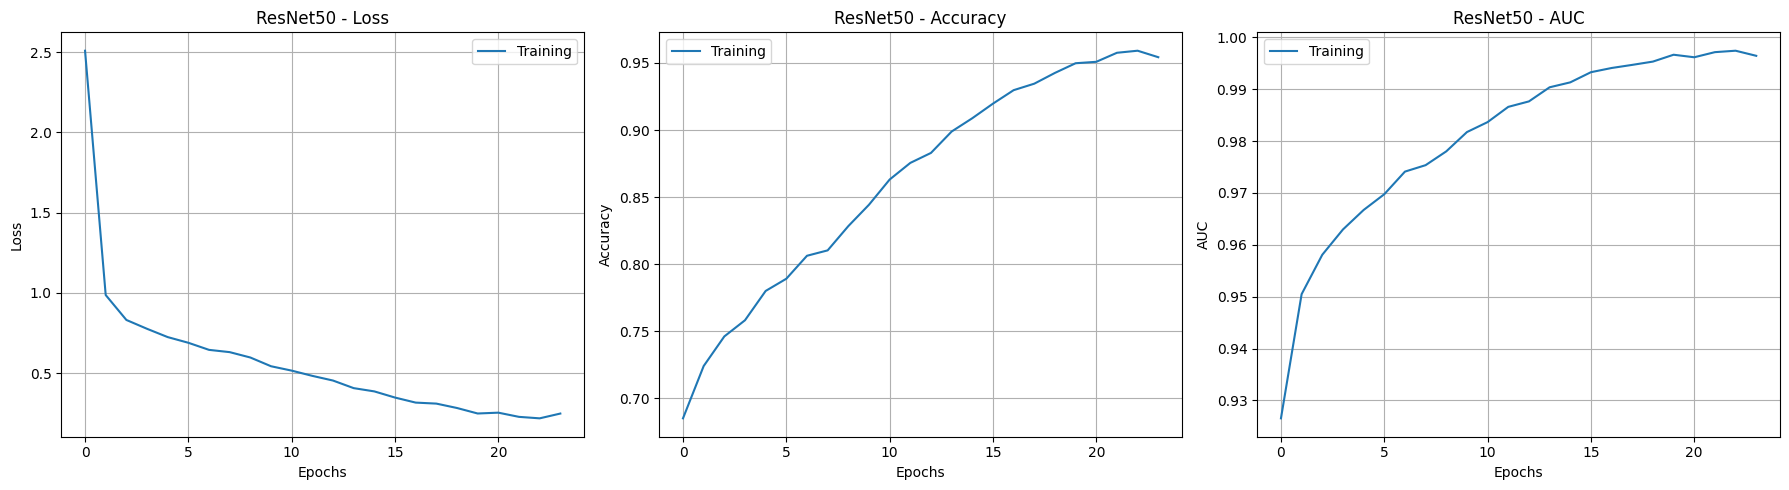


Evaluating on test set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 326ms/step - accuracy: 0.7364 - auc: 0.8974 - loss: 1.8550

Test Loss for ResNet50: 1.8392
Test Accuracy for ResNet50: 0.7252
Test AUC for ResNet50: 0.8979

Generating predictions for ROC curves...
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 301ms/step


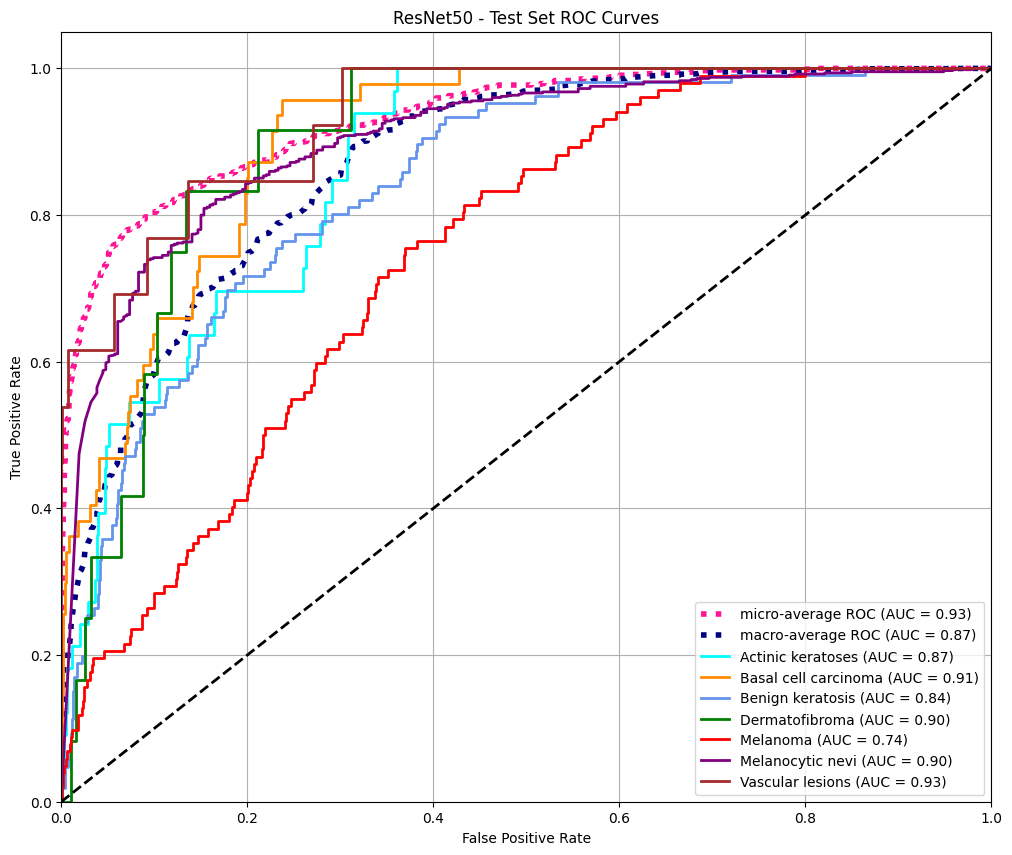


Generating confusion matrix...


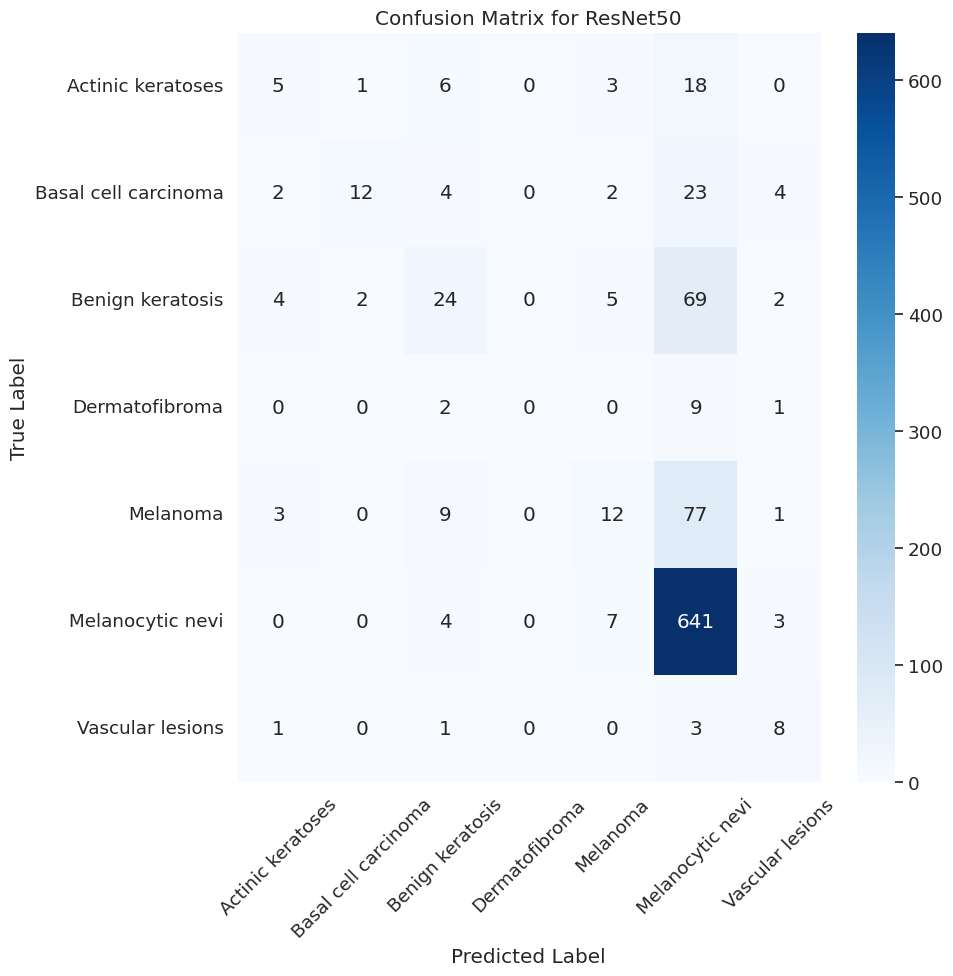


Classification Report:
                      precision    recall  f1-score   support

   Actinic keratoses       0.33      0.15      0.21        33
Basal cell carcinoma       0.80      0.26      0.39        47
    Benign keratosis       0.48      0.23      0.31       106
      Dermatofibroma       0.00      0.00      0.00        12
            Melanoma       0.41      0.12      0.18       102
    Melanocytic nevi       0.76      0.98      0.86       655
    Vascular lesions       0.42      0.62      0.50        13

            accuracy                           0.73       968
           macro avg       0.46      0.33      0.35       968
        weighted avg       0.67      0.73      0.67       968


Final Training and Evaluation for model: DenseNet201

Balancing full training data for final model...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced full training set size: 8464 samples
Found 8464 validated image filenames belonging to 7 classes.
Found 968 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 117s 287ms/step - accuracy: 0.3058 - auc: 0.6410 - loss: 2.7507 - learning_rate: 0.0010
Epoch 2/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 53s 200ms/step - accuracy: 0.6182 - auc: 0.8643 - loss: 1.3159 - learning_rate: 0.0010
Epoch 3/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 53s 200ms/step - accuracy: 0.6844 - auc: 0.9104 - loss: 1.0211 - learning_rate: 0.0010
Epoch 4/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 52s 197ms/step - accuracy: 0.6823 - auc: 0.9257 - loss: 0.9312 - learning_rate: 0.0010
Epoch 5/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 53s 198ms/step - accuracy: 0.6984 - auc: 0.9353 - loss: 0.8726 - learning_rate: 0.0010
Epoch 6/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 53s 200ms/step - accuracy: 0.6985 - auc: 0.9345 - loss: 0.8770 - learning_rate: 0.0010
Epoch 7/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 53s 198ms/step - accuracy: 0.7180 - auc: 0.9431 - loss: 0.8141 - learning_rate: 0.0010
Epoch 8/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 53s 200ms/step - accuracy: 0.7149 - auc: 0.9459 - loss: 0.7999 - learn

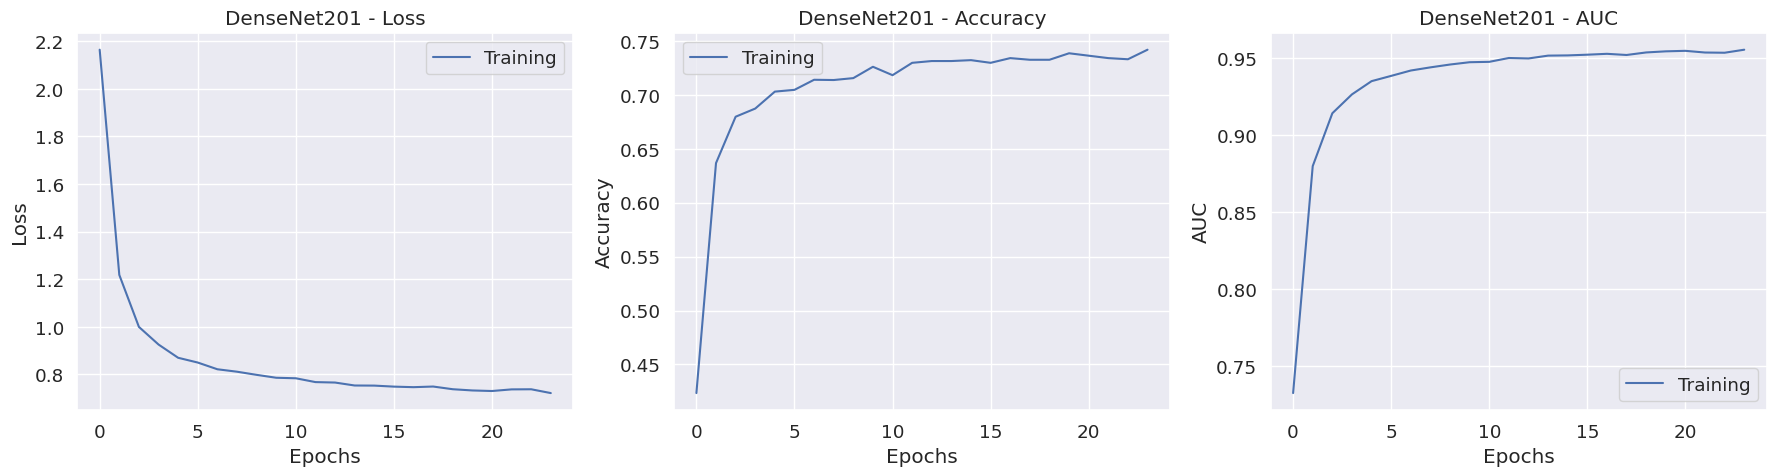


Evaluating on test set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 811ms/step - accuracy: 0.7550 - auc: 0.9601 - loss: 0.6849

Test Loss for DenseNet201: 0.6893
Test Accuracy for DenseNet201: 0.7469
Test AUC for DenseNet201: 0.9597

Generating predictions for ROC curves...
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 844ms/step


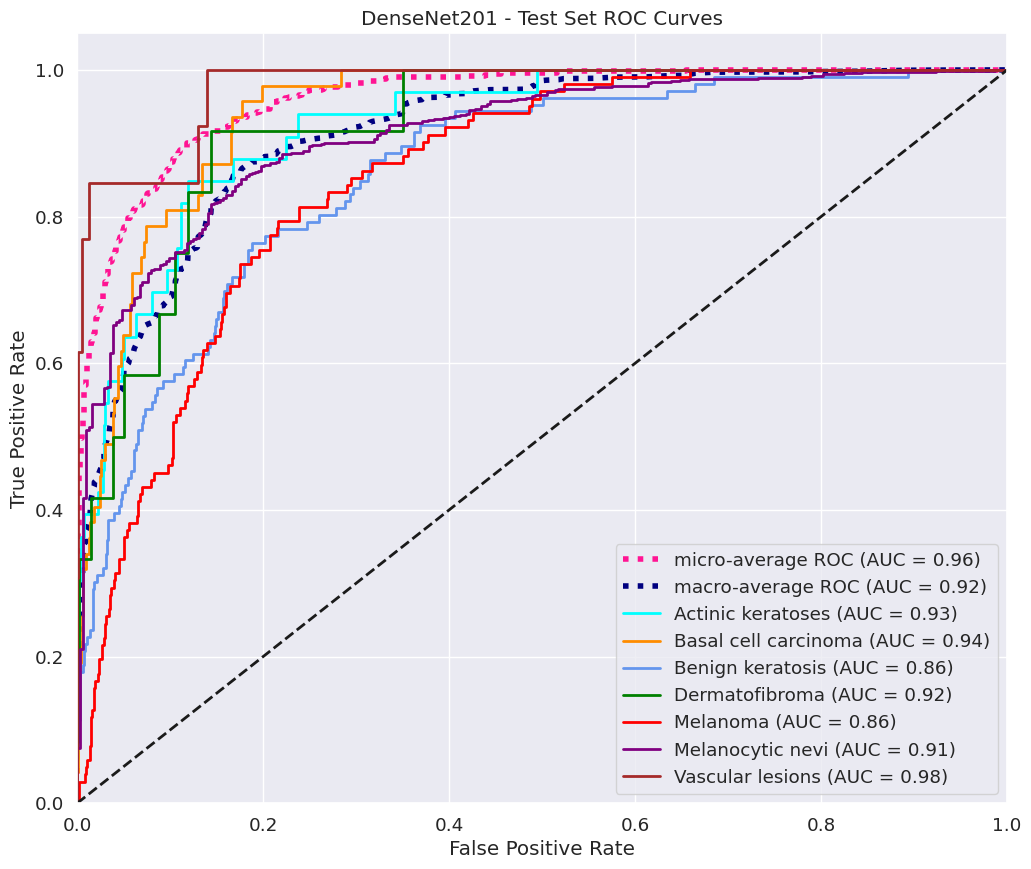


Generating confusion matrix...


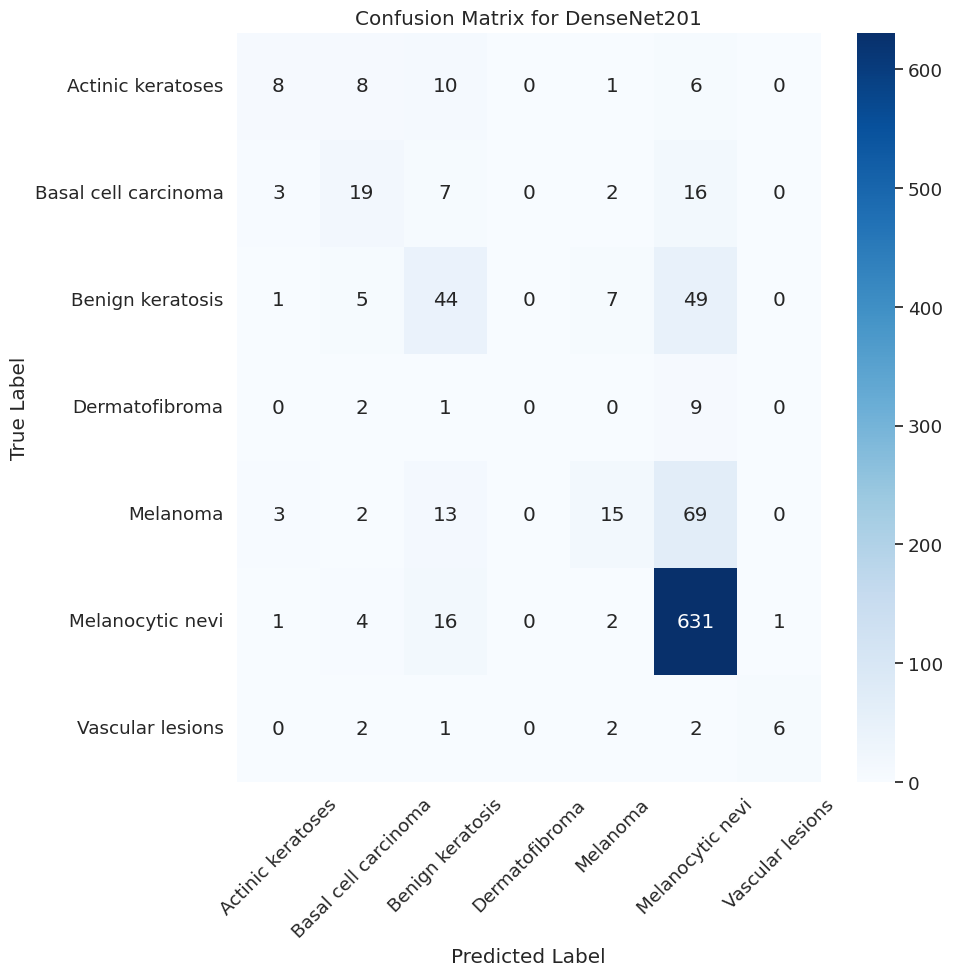


Classification Report:
                      precision    recall  f1-score   support

   Actinic keratoses       0.50      0.24      0.33        33
Basal cell carcinoma       0.45      0.40      0.43        47
    Benign keratosis       0.48      0.42      0.44       106
      Dermatofibroma       0.00      0.00      0.00        12
            Melanoma       0.52      0.15      0.23       102
    Melanocytic nevi       0.81      0.96      0.88       655
    Vascular lesions       0.86      0.46      0.60        13

            accuracy                           0.75       968
           macro avg       0.52      0.38      0.42       968
        weighted avg       0.70      0.75      0.71       968


Final Training and Evaluation for model: EfficientNetB3

Balancing full training data for final model...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced full training set size: 8464 samples
Found 8464 validated image filenames belonging to 7 classes.
Found 9

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 112s 291ms/step - accuracy: 0.3659 - auc: 0.6886 - loss: 2.5611 - learning_rate: 0.0010
Epoch 2/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 57s 216ms/step - accuracy: 0.6330 - auc: 0.8772 - loss: 1.2404 - learning_rate: 0.0010
Epoch 3/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 58s 219ms/step - accuracy: 0.6771 - auc: 0.9111 - loss: 1.0206 - learning_rate: 0.0010
Epoch 4/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 58s 217ms/step - accuracy: 0.6978 - auc: 0.9296 - loss: 0.9043 - learning_rate: 0.0010
Epoch 5/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 58s 217ms/step - accuracy: 0.7034 - auc: 0.9391 - loss: 0.8465 - learning_rate: 0.0010
Epoch 6/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 57s 216ms/step - accuracy: 0.7122 - auc: 0.9438 - loss: 0.8116 - learning_rate: 0.0010
Epoch 7/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 58s 219ms/step - accuracy: 0.7298 - auc: 0.9460 - loss: 0.7932 - learning_rate: 0.0010
Epoch 8/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 58s 220ms/step - accuracy: 0.7210 - auc: 0.9455 - loss: 0.7973 - learn

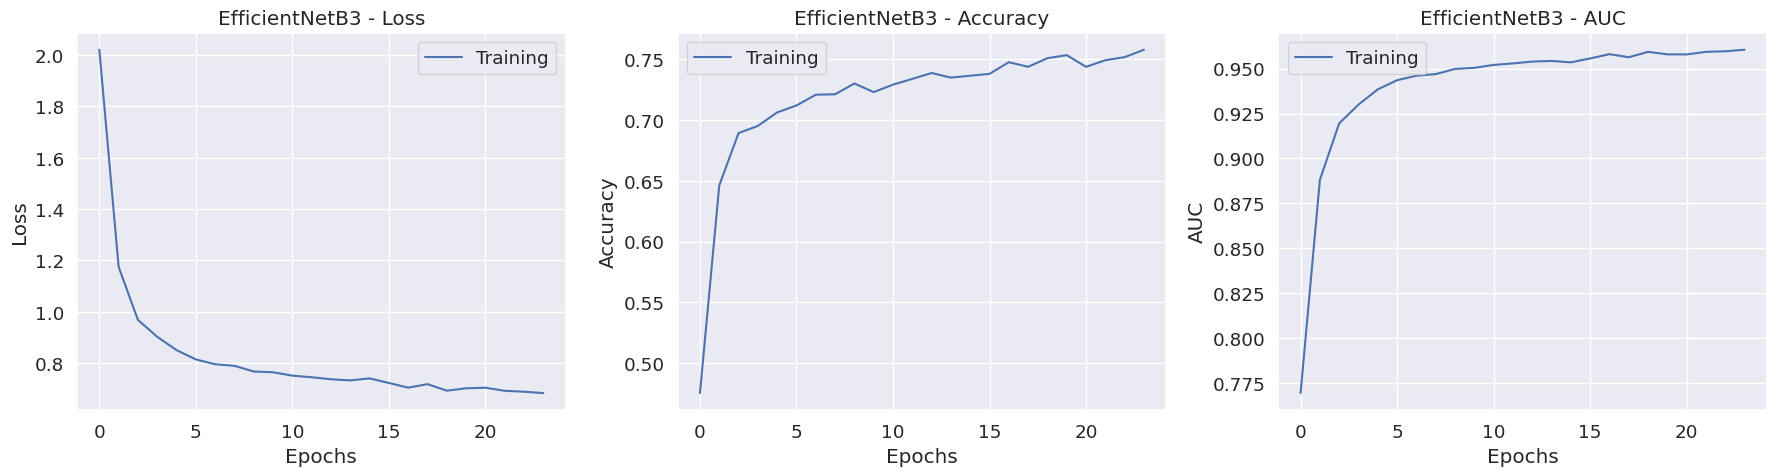


Evaluating on test set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 506ms/step - accuracy: 0.7708 - auc: 0.9637 - loss: 0.6505

Test Loss for EfficientNetB3: 0.6899
Test Accuracy for EfficientNetB3: 0.7438
Test AUC for EfficientNetB3: 0.9595

Generating predictions for ROC curves...
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 494ms/step


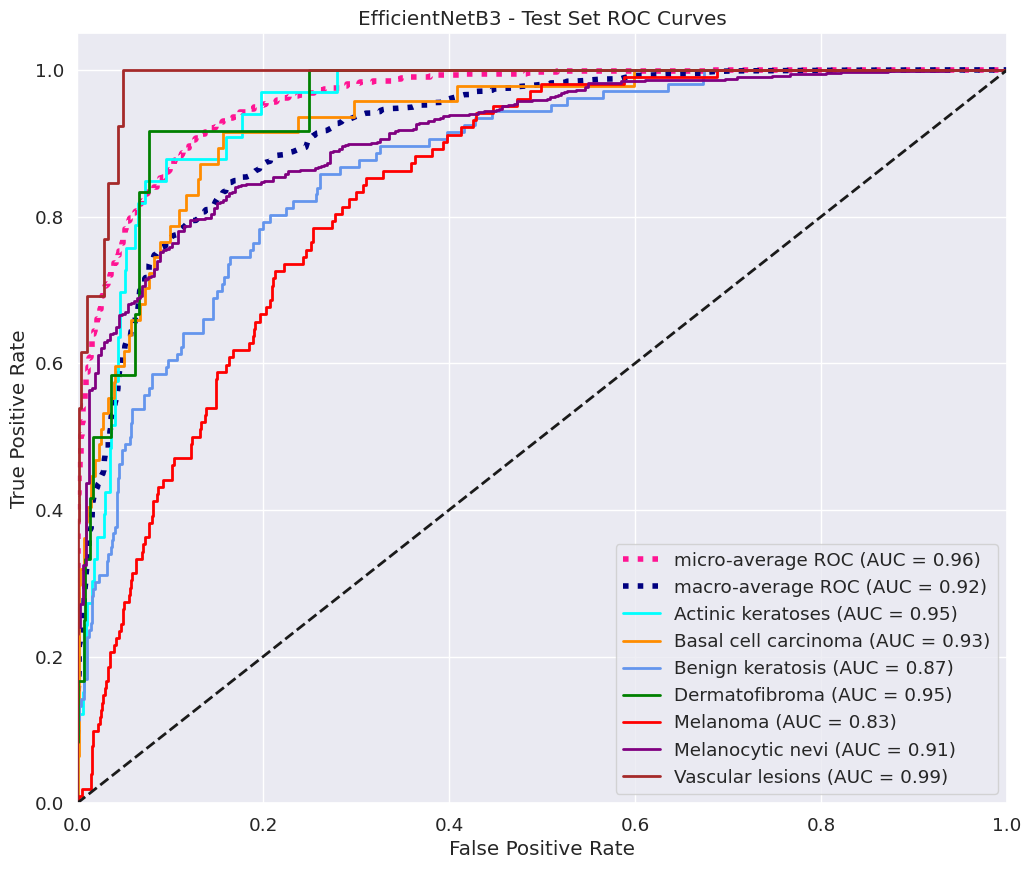


Generating confusion matrix...


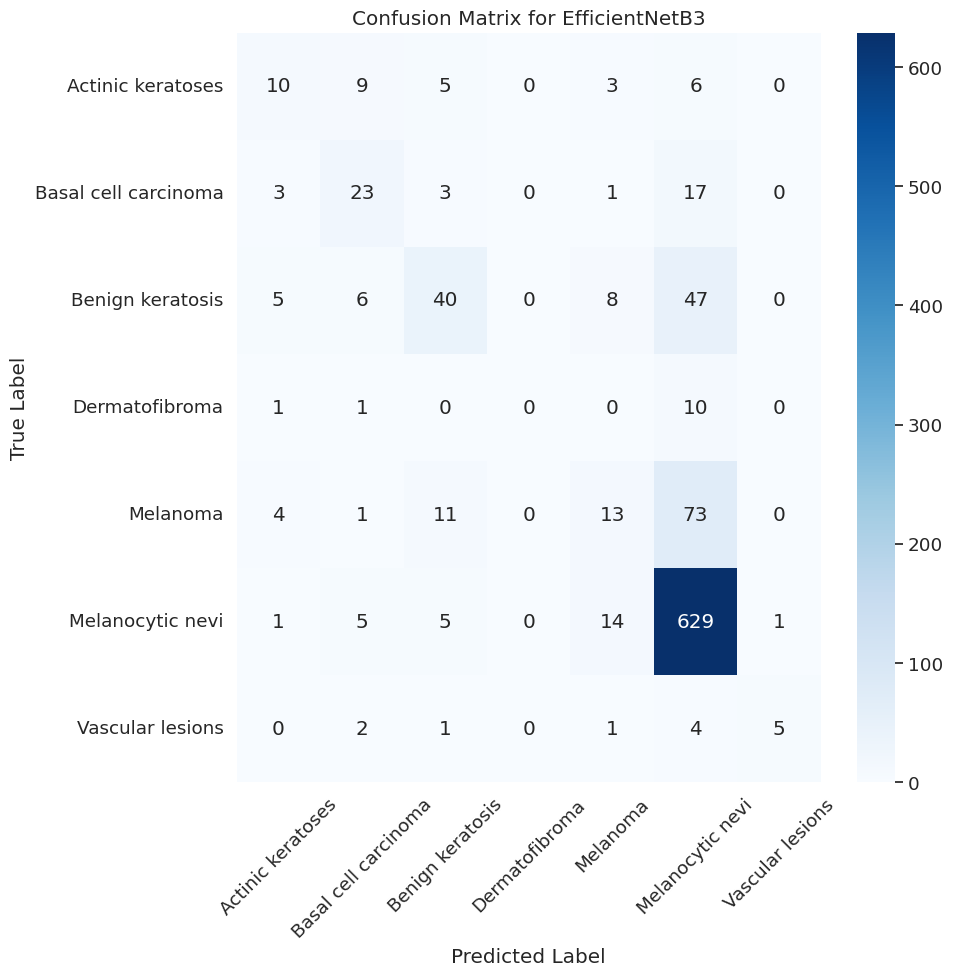


Classification Report:
                      precision    recall  f1-score   support

   Actinic keratoses       0.42      0.30      0.35        33
Basal cell carcinoma       0.49      0.49      0.49        47
    Benign keratosis       0.62      0.38      0.47       106
      Dermatofibroma       0.00      0.00      0.00        12
            Melanoma       0.33      0.13      0.18       102
    Melanocytic nevi       0.80      0.96      0.87       655
    Vascular lesions       0.83      0.38      0.53        13

            accuracy                           0.74       968
           macro avg       0.50      0.38      0.41       968
        weighted avg       0.69      0.74      0.70       968



In [8]:
for model_name, config in model_configs.items():
    print("\n================================================")
    print(f"Final Training and Evaluation for model: {model_name}")
    print("================================================")

    img_size = config["img_size"]
    use_rescale = config["use_rescale"]
    model_func = config["model_func"]

    print("\nBalancing full training data for final model...")
    balanced_df_train = balance_data(df_train, oversample=USE_AUGMENTATION_AND_OVERSAMPLING)
    print(f"Final balanced full training set size: {len(balanced_df_train)} samples")

    if use_rescale:
        train_gen_full = tr_gen_rescale.flow_from_dataframe(
            balanced_df_train,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=True,
            batch_size=batch_size
        )
        test_gen = ts_gen_rescale.flow_from_dataframe(
            df_test,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=False,
            batch_size=batch_size
        )
    else:
        train_gen_full = tr_gen_no_rescale.flow_from_dataframe(
            balanced_df_train,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=True,
            batch_size=batch_size
        )
        test_gen = ts_gen_no_rescale.flow_from_dataframe(
            df_test,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=False,
            batch_size=batch_size
        )

    num_classes = len(train_gen_full.class_indices)
    model = model_func(input_shape=(img_size[0], img_size[1], 3), num_classes=num_classes)
    model = compile_model(model)

    final_lr_reduction = ReduceLROnPlateau(
        monitor='accuracy',
        patience=3,
        verbose=1,
        factor=0.5,
        min_lr=0.00001
    )

    print("\n--- Final training on full training data ---")
    history_full = model.fit(
        train_gen_full,
        epochs=num_epochs,
        callbacks=[final_lr_reduction],
        verbose=1
    )

    plot_training_history(history_full, model_name)

    print("\nEvaluating on test set...")
    score = model.evaluate(test_gen)
    loss, accuracy, auc_value = score
    print(f"\nTest Loss for {model_name}: {loss:.4f}")
    print(f"Test Accuracy for {model_name}: {accuracy:.4f}")
    print(f"Test AUC for {model_name}: {auc_value:.4f}")

    print("\nGenerating predictions for ROC curves...")
    y_pred = model.predict(test_gen)
    y_true = np.array(test_gen.classes)
    class_names = list(test_gen.class_indices.keys())

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        y_true_binary = np.array(y_true == i, dtype=int)
        fpr[i], tpr[i], _ = roc_curve(
            y_true_binary,
            y_pred[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(
        tf.keras.utils.to_categorical(y_true, num_classes=num_classes).ravel(),
        y_pred.ravel()
    )
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lesion_names = [lesion_type_dict[key] for key in class_names]
    plot_roc_curves(fpr, tpr, roc_auc, lesion_names, f"{model_name} - Test Set ROC Curves")

    print("\nGenerating confusion matrix...")
    predictions = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, predictions)

    plt.figure(figsize=(10,10))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[lesion_type_dict[key] for key in class_names],
                yticklabels=[lesion_type_dict[key] for key in class_names])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(
        y_true,
        predictions,
        target_names=[lesion_type_dict[key] for key in class_names],
        zero_division=0
    ))

    del model
    tf.keras.backend.clear_session()
    gc.collect()